# Benchmarking Feature Selection Techniques

(On non-genomic problems)  

Unfortunately, most benchmarking of feature selection techniques I can find in the literature focuses on genomic data with p>>n, e.g. 1,000 examples and 5,000 features. For most realistic problems I've encountered in industry, feature selection is more a matter of convenience and engineering constraints rather than raw model performance. (E.g. we can literally run a model on 200 features and 100k examples, but we don't want to maintain the feature pipeline for all 200 features. For the problems here, we have at least 10x and often 100x more examples than features, which is consistent with my experience.)  

I'll also contrast _feature selection_, where we e.g. want to select _k_ features or x% of features with _all relevant feature selection_, where we want to remove all noise features or (closely related) remove features to increase model performance. (An example would be the great Boruta, https://github.com/scikit-learn-contrib/boruta_py, selecting by p-value or FDR or FWER, or the more well-known recursive feature elimination implemented in sklearn.) In traditional feature selection, we want to reduce the number of features, and we may or may not expect to improve model performance.  

data sources - see dataset names

__methods__

- pick 12 ish datasets with n >> m, typically 100+ examples per feature, mostly >10k examples, e.g. semi-realistic real-world datasets (not synthetic, not m>n)  
- filter on statistical or AUC threshold (FDR, RFE) or top-k (F statistic, MI, from-model)  
- use same vanilla pipeline otherwise (impute mean + indicator, smoothed target encoding, quantile transform to normal, non-tuned but reasonable hyperparameters xgboost)  
- compare performance :)  

__performance/results__

given that we don't have M > N, simply not feature selecting is very competitive (typically does best, keep in mind I'm using a model which performs some very simplistic automatic feature selection and regularization). RFE and FDR filtering - which will likely leave most features in - cost us little/nothing in performance with a simpler model. Everything else - selecting K top features where I arbitrarily set K to 20 - costs us a nontrivial bit - permutation, gain, and SHAP importance all do about equally well (what about split importance?). Simpler univariate schemes - F-statistic, rank _r_ statistic, MI - do a bit worse with the nonlinear rank-r and MI doing better. Our feature extraction techniques - PCA and feature agglomeration - do worst. Note that feature agglomeration did well on some smaller datasets, so could be worth considering if you (1) don't care about interpretability and (2) have very small N. _I ran into issues running relief-based and JMI+JMIM on these "ML-sized" (i.e. not "statistically sized" few hundred-to-thousand examples) so am not able to include those results._  

- on many problems, selecting by F or mutual information perform similarly - but sometimes MI does much better, presumably when there are strongly nonlinear relationships  
- selecting by LGB or XGB split gain does better than MI on reasonably-sized datasets (can e.g. account for interactions), and it's faster (no nearest neighbor computation). in this example, SHAP on non-subsampled data did best by a very slight margin, and tree gain is nearly as good and noticeably faster. permutation importance seemingly does worse, and it's slower than SHAP, so I wouldn't bother with it in the future :)   
- PCA is generally not a great way to reduce dimensionality for supervised tasks. (and again, it's feature extraction, not feature selection. and it harms interpretability)  
- RFE gives us basically the exact same results as just fitting the model on all features, but presumably helps reduce the data size slightly  
- Selecting by FDR (presumably) reduces dimensionality with very little harm. on the few smaller datsets I included, it actually helps. (Here's the part where I complain that sklearn still doesn't have a dataframe interface, so you'll have to hack around a little to get feature names from numeric indexes.)  

__speed__  

RFE CV (unsurprising) and permuation importance (also not too surprising) are the slowest. Mutual information relies on nearest-neighbors, which scales poorly to large N (O(N^2))), so it's also pretty slow on larger datasets but pretty fast on smaller ones. our various linear filters (F-test, FDR) and one-pass tree filters are fast, as is just fitting the model. (pre-filtering with a simple tree model actually tends to save time since our final tree model is noticeably larger.)  

__TL;DR / "just tell me what do"__

- if you just care about model performance and have reasonably easy/high information problem and don't care about feature pipeline complexity or interpretability, just throw your features into a GBT, and you've got yourself a stew  
- you'll simplify your model without much cost in performance by filtering non-significant features (e.g. FDR)  
- if you need to prune more for engineering or interpretability reasons, you won't do better than selecting from SHAP values; selecting from (especially LGBM) gain feature importances is nearly as good and noticeably faster.  
- if you have as many features as examples, you're reading the wrong notebook and there are a million scholarly articles available to answer your question :)  

In [1]:
#!conda install -c conda-forge scikit-learn-intelex -y

In [2]:
#!conda install -c anaconda mkl -y


In [3]:
#import IPython; IPython.get_ipython().execution_count = 0


In [4]:
import pprint
import numpy as np

# silence warnings from xgb using deprecated interface
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import xgboost as xgb
import lightgbm as lgb
import shap
#import eli5
from IPython.core.interactiveshell import InteractiveShell
import os
from sklearnex import patch_sklearn
import gc

# try to make this as un-slow as we can ;)
patch_sklearn()

np.show_config()
pd.show_versions()

p = pprint.PrettyPrinter(indent=2).pprint

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%config InlineBackend.figure_format='retina'
pd.set_option('display.max_columns', 50)
plt.style.use('dark_background')

/home/jan/miniconda3/envs/feature-selection/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Setuptools is replacing distutils.


blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/jan/miniconda3/envs/feature-selection/lib']
    include_dirs = ['/home/jan/miniconda3/envs/feature-selection/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/jan/miniconda3/envs/feature-selection/lib']
    include_dirs = ['/home/jan/miniconda3/envs/feature-selection/include']
    language = c
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/home/jan/miniconda3/envs/feature-selection/lib']
    language = f77
lapack_opt_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas', 'cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/jan/miniconda3/envs/feature-selection/lib']
    language = c
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    include_dirs = ['/hom

## Load Data  

Santander and KDD98 datasets from Openml.org; foo and bar from Penn Machine Learning Benchmarks. Thanks to them for providing this service to the world.  
I've intentionally chosen the Santander and KDD98 datasets for their non-trivial scale (50k+ examples, would have preferred larger) and a decent number of features (50+).  

Santander and KDD98 are famous ML benchmarking datasets, APSFailure and Albert seemed to fit my criteria but aren't well-known to me.  

For simplicity, I've only chosen datasets with binary outcomes, but some of them do have noticeable class imbalance.

In [5]:
def auto_encode_categoricals(
    df: pd.DataFrame, thresh_uniq_vals: float = 0.01, verbose: bool = True
) -> pd.DataFrame:
    """
    Convert all object / string columns with (# uniq vals / # total vals) < threshold to category.
    Note: Rarely, a column will need to be 'object' (Python object) type 
      to be compatible with Pandas functions.
    df: pd.DataFrame, to downcast to categorical
    thresh_uniq_vals: float, proportion of unique values to require to downcast
    """
    cols = df.select_dtypes(include=["object"]).columns.tolist()
    thresh_absolute = thresh_uniq_vals * len(df)
    cat_cols = [col for col in cols if (len(df[col].unique()) < thresh_absolute)]
    if verbose:
        print("Converting these columns to categorical:")
        print(cat_cols)
    # Have to use a for here due to pd limitation:
    for col in cat_cols:
        df[col] = df[col].copy(deep=True).astype("category")
    return df


def downcast_int(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Downcast numeric types in a DataFrame to save memory.
    Note: this will end up dropping duplicated columns, 
          but one would hope you haven't duplicated columns.
    Note 2: some Pandas operations may only exist for floats or higher-bit ints.
    
    df: pd.DataFrame, to downcast
    """
    full = df.copy()
    # We can run into issues if we have duplicated columns - drop them.
    full = df.loc[:, ~df.columns.duplicated()]
    df = full.select_dtypes(include=[np.number])
    num_cols = df.columns
    non_num_cols = set(full.columns) - set(df.columns)
    for col in num_cols:
        not_null = not df[col].isnull().any()
        not_small = df[col].abs().mean() > 1.10  # avoid round small floats to 0
        not_fractional = np.isclose(df[col].values, df[col].round(0).values).all()
        downcast = not_null and not_small and not_fractional
        if downcast:
            if verbose:
                print(f"Downcast column {col}")
            df.loc[:, col] = pd.to_numeric(df[col].copy(deep=True), downcast="integer")
        else:
            pass

    df = pd.concat([full[list(non_num_cols)], df], axis="columns")
    return df

def downcast_float(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Downcast 64-bit float to 32-bit. 
    Will cost ~0 performance and save us 50% memory on float cols.
    """
    float_cols = df.select_dtypes(include=['float']).columns.tolist()
    if verbose:
        print('Downcast float to 32-bit', float_cols)
    df[float_cols] = df[float_cols].astype('float32')
    return df

In [6]:
def preprocess_df(df: pd.DataFrame, target_colname: str, target_class_balance: float = 3.0) -> pd.DataFrame:
    df = df.copy(deep=True)
    df = df.sample(frac=1, random_state=SEED)  # shuffle
    df = df.reset_index(drop=True)
    df = df.rename(columns=str.lower)
    df = df.rename(columns={target_colname: 'target'})
    df.target = df.target.astype('int8')
    # Not interested in highly imbalanced cases, downsample randomly to 1:5 as needed.
    # Note: we shuffle on data load so can just take first 3*n_minority_class sequentially.
    # (Also assume 1 is minority class.)
    class_balance = (1 / df.target.mean())
    if class_balance > target_class_balance:
        print('downsample')
        n_1s = df.target.sum()
        df = df.loc[((df.target == 1) | (df.index <= ((1 + target_class_balance) * n_1s)))]
    null_cols = df.columns[df.isna().mean() > .95]
    df = df.drop(null_cols, axis=1)
    df = auto_encode_categoricals(df)
    df = downcast_int(df, verbose=0)
    df = downcast_float(df)
    gc.collect()
    return df

In [7]:
SEED = 42
santander = pd.read_csv("../data/santander.csv")
santander = preprocess_df(santander, 'target')
santander.target.value_counts()  # basic class balance
santander

kdd = pd.read_csv("../data/kdd98.csv").sample(frac=1, random_state=SEED)  # shuffle
kdd = preprocess_df(kdd, 'target_b')
kdd.target.value_counts()
kdd


kdd_census = pd.read_csv("../data/openml-kdd-census-income.csv")
kdd_census = kdd_census.rename(columns={'income_50k': 'target'})
kdd_census.target = kdd_census.target == "' 50000+.'"
kdd_census = preprocess_df(kdd_census, 'target')
kdd_census.target.value_counts()
kdd_census

downsample
Converting these columns to categorical:
[]
Downcast float to 32-bit ['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89', 'var_90', 'var_91', 'var_92',

0    72258
1    20098
Name: target, dtype: int64

,id_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,...,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_119737,0,11.0038,-4.5026,9.0662,6.4313,10.7061,-15.2857,5.1233,16.787500,4.1833,8.4055,-4.1540,-10.8329,14.2550,3.1023,8.3950,14.6973,9.3601,-16.2458,25.210300,5.2981,25.709000,26.213800,3.1250,...,8.1378,-8.2284,8.8929,-4.6192,0.8818,-9.0733,10.0524,8.882300,7.9633,2.924700,-1.8443,4.4832,-23.873699,11.063800,-0.5127,-0.8200,3.3085,3.1358,5.0959,19.716000,-0.1801,5.8437,8.8348,17.046101,8.8190
1,train_72272,0,12.8473,-6.1848,6.8799,2.0164,12.7998,10.2781,4.4191,15.694000,-0.6788,8.9070,-7.8677,4.3768,13.9440,8.0701,8.7038,14.3273,11.9843,-18.4636,28.085501,10.8519,15.467800,38.922501,1.0837,...,8.7345,-4.1818,14.0352,7.3551,1.4468,-15.6600,9.6867,1.331600,5.7320,29.549601,-13.7862,3.5507,-32.826900,15.575300,2.0424,1.1516,3.9019,4.6616,7.6035,12.640200,-0.3037,-4.2330,9.7456,14.833700,-3.7167
2,train_158154,0,13.1827,-0.8344,13.4689,3.9060,13.5984,4.6475,5.9659,24.055700,3.8743,7.6350,-4.2686,-10.2086,13.7723,13.6299,3.9546,14.7699,5.7576,2.2429,11.788200,4.1893,23.304701,27.595900,2.6682,...,9.4352,0.1989,8.6130,15.0827,0.5547,-9.8419,9.8494,-6.085700,-1.6701,4.129500,-14.1248,11.3229,-11.376000,13.969200,0.1606,2.8737,5.8939,0.8525,8.7406,16.664101,0.8745,7.0406,8.6424,20.710699,-5.4186
3,train_65426,0,8.2132,1.2309,11.1464,9.4524,10.2142,4.0416,5.3989,20.452700,0.2915,6.3123,-6.9638,-2.6824,14.0316,1.9909,6.1070,14.7762,9.9599,-21.4055,6.782800,10.1881,1.284600,11.772100,8.9509,...,11.1943,-7.1989,12.0702,-5.5935,5.5068,4.7851,9.4399,-7.368700,6.7793,16.089600,5.6344,6.4042,-24.588400,6.870000,1.0351,6.4752,5.7442,2.1907,6.0651,10.944400,-2.0666,-7.9209,9.0522,17.173500,12.4656
4,train_30074,1,5.5681,4.6355,15.2350,3.0718,11.8178,-15.0502,3.8357,12.016900,3.2997,6.3261,0.4133,-10.7155,14.0147,3.8835,6.2724,14.0034,8.0050,1.3897,14.251900,16.8915,16.541100,2.494000,11.0470,...,10.9190,-7.1533,12.6144,-1.0282,7.0979,2.3174,10.6060,6.493000,2.6453,19.203899,-2.3856,9.6478,-7.192100,17.256901,1.3937,4.1796,5.6113,-0.1561,3.1010,17.429701,-1.0121,-6.5168,7.9772,18.524799,11.2771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199977,train_199041,1,6.8000,0.0966,9.0483,9.8033,9.2290,-10.3801,7.4430,16.756399,0.4090,7.8064,4.6179,-15.8374,13.6773,12.3689,2.9457,15.3304,12.1943,-17.2861,15.005900,9.6611,15.537300,6.120700,2.1877,...,7.7312,3.9337,15.5897,13.7599,7.6076,-6.9162,8.3089,-11.805100,6.3953,5.052900,-6.6549,14.5169,-28.394400,19.915600,-0.2240,6.5040,4.4405,5.3446,13.6202,21.132500,2.2498,8.3546,9.3611,19.279699,-2.3842
199985,train_16023,1,13.3079,-5.7326,10.6380,8.1817,11.1339,-5.7439,4.0670,11.369000,-1.2361,5.1038,2.4564,-0.7785,13.9685,9.8781,7.6368,14.5328,12.8783,-2.2193,9.367700,5.6844,12.127600,26.671700,6.8453,...,7.9055,-8.1262,9.9513,10.4145,1.3645,-10.1677,11.5362,3.080700,9.6548,17.691700,0.7609,6.1894,-3.703800,16.874800,1.1705,4.2393,6.6742,2.6361,-0.3521,18.438700,0.8632,10.0196,8.5242,9.239800,-13.4449
199986,train_191335,1,7.7407,2.8590,7.1075,6.6993,10.7365,-6.2643,4.1604,15.998900,-1.2521,8.1850,0.4390,-10.0020,13.8518,-1.5163,6.7997,14.2064,12.4626,-6.0370,27.413099,2.7953,6.888300,14.113600,7.4047,...,10.1619,-8.2610,7.8050,-10.0768,9.0769,-1.7855,9.3193,-5.128800,11.0297,16.433500,-4.5762,10.6912,-27.512400,13.761300,-1.1508,4.2474,6.3600,-0.1371,-0.1414,12.926900,-2.0946,0.0568,7.6435,11.791900,6.2708
199988,train_126324,1,18.6411,-1.2222,15.0769,5.7507,9.3010,13.3000,5.2070,14.954400,-2.9257,5.4263,2.7005,-5.3081,14.0665,3.7763,10.4029,15.0684,6.8191,-14.0308,12.369

Columns (305,396) have mixed types. Specify dtype option on import or set low_memory=False.


downsample
Converting these columns to categorical:
['adate_10', 'adate_11', 'adate_12', 'adate_13', 'adate_14', 'adate_15', 'adate_16', 'adate_17', 'adate_18', 'adate_19', 'adate_20', 'adate_21', 'adate_22', 'adate_23', 'adate_24', 'adate_3', 'adate_4', 'adate_5', 'adate_6', 'adate_7', 'adate_8', 'adate_9', 'age', 'ageflag', 'bible', 'boats', 'cards', 'catlg', 'cdplay', 'child03', 'child07', 'child12', 'child18', 'cluster', 'collect1', 'crafts', 'datasrce', 'domain', 'fisher', 'gardenin', 'gender', 'geocode', 'geocode2', 'homee', 'homeownr', 'income', 'kidstuff', 'lifesrc', 'magfaml', 'magfem', 'magmale', 'mailcode', 'major', 'mbbooks', 'mbcolect', 'mbcraft', 'mbgarden', 'mdmaud', 'mdmaud_a', 'mdmaud_f', 'mdmaud_r', 'nextdate', 'noexch', 'numchld', 'pcowners', 'pepstrfl', 'pets', 'photo', 'plates', 'pubculin', 'pubdoity', 'pubgardn', 'pubhlth', 'pubnewfn', 'pubopp', 'pubphoto', 'pvastate', 'ramnt_10', 'ramnt_11', 'ramnt_12', 'ramnt_13', 'ramnt_14', 'ramnt_15', 'ramnt_16', 'ramnt_17', 

0    34221
1     9690
Name: target, dtype: int64

,adate_18,rfa_3,ramnt_6,pubculin,ramnt_24,rfa_8,rdate_23,rdate_7,rfa_2,kidstuff,rfa_9,mbbooks,mbgarden,rfa_20,ramnt_21,ramnt_11,adate_13,recpgvg,rdate_21,veterans,rfa_11,mdmaud_f,pubphoto,ramnt_9,rfa_21,...,stategov,target,tcode,tpe1,tpe10,tpe11,tpe12,tpe13,tpe2,tpe3,tpe4,tpe5,tpe6,tpe7,tpe8,tpe9,vc1,vc2,vc3,vc4,vietvets,voc1,voc2,voc3,wwiivets
0,9501_0,S2E,?,?,10,S4E,9408_0,NaN,L2E,_,S4E,?,?,_,?,?,9507_0,_,NaN,_,S4E,X,?,?,A4E,...,3,1,1,83,23,24,2,70,6,3,3,0,0,1,2,5,28,22,24,0,28,99,85,32,24
1,9501_0,A1E,?,0,?,A1E,NaN,NaN,L1E,_,A1E,1,0,S2D,?,?,NaN,_,NaN,_,A1E,X,0,?,S2D,...,4,0,0,72,19,25,4,61,15,1,1,0,0,0,9,3,38,27,14,13,38,90,61,23,14
2,9501_0,A1F,?,0,?,A2F,NaN,NaN,L1F,_,A2F,0,0,A1E,?,?,9507_0,_,NaN,Y,A2F,X,0,?,A1E,...,0,0,2,79,12,14,0,34,15,2,0,0,2,1,3,0,9,25,35,32,9,95,51,11,35
3,9501_0,A1G,?,?,?,S2G,NaN,NaN,L1G,_,S2G,?,?,A1E,20,?,9507_0,_,9412_0,_,A1F,X,?,?,A1E,...,9,0,28,76,14,21,8,41,6,5,5,0,0,0,10,3,32,15,55,13,32,91,47,7,55
4,9501_0,A1G,?,?,?,A1G,NaN,NaN,L1G,_,_,?,?,_,?,?,NaN,_,NaN,_,I1G,X,?,?,L1G,...,0,0,0,86,23,28,4,71,7,0,0,0,0,1,2,5,41,32,27,7,41,99,64,10,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82293,9501_0,S2E,?,0,11,S3E,NaN,NaN,L2E,_,S4E,2,0,_,?,?,9507_0,_,NaN,_,S3E,X,0,?,S2E,...,28,1,0,76,9,11,2,11,9,0,0,0,0,0,14,1,30,17,23,10,30,95,64,21,23
82302,9412_0,S3E,?,?,?,A3E,NaN,NaN,L3E,_,A3E,?,?,A2D,?,10,9507_0,_,NaN,_,A3E,X,?,?,A2D,...,4,1,28,91,17,19,1,65,8,0,0,0,0,0,1,0,27,18,22,35,27,98,41,5,22
82303,9412_0,A1F,?,?,?,A2F,NaN,NaN,L1F,_,A2F,?,?,N2D,?,?,9507_0,_,NaN,_,A2F,X,?,?,N2D,...,5,1,1,81,17,21,1,61,14,4,4,0,0,0,2,0,51,10,10,25,20,99,73,29,23
82305,9501_0,A1F,?,?,?,A1F,NaN,NaN,L1F,_,N1E,?,?,_,?,?,9507_0,_,NaN,_,N1E,X,?,?,P1A,...,18,1,0,64,15,20,5,48,23,0,0,0,0,2,9,2,18,16,39,18,18,84,38,8,39


downsample
Converting these columns to categorical:
['class_worker', 'education', 'hs_college', 'marital_stat', 'major_ind_code', 'major_occ_code', 'race', 'hisp_origin', 'sex', 'union_member', 'unemp_reason', 'full_or_part_emp', 'tax_filer_stat', 'region_prev_res', 'state_prev_res', 'det_hh_fam_stat', 'det_hh_summ', 'mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_same', 'mig_prev_sunbelt', 'fam_under_18', 'country_father', 'country_mother', 'country_self', 'citizenship', 'vet_question']
Downcast float to 32-bit ['unknown']


0    46587
1    12382
Name: target, dtype: int64

,country_father,country_mother,unemp_reason,vet_question,mig_prev_sunbelt,class_worker,race,sex,det_hh_fam_stat,hisp_origin,major_occ_code,state_prev_res,hs_college,mig_move_reg,education,major_ind_code,union_member,mig_same,region_prev_res,fam_under_18,full_or_part_emp,country_self,marital_stat,citizenship,mig_chg_msa,tax_filer_stat,det_hh_summ,mig_chg_reg,age,det_ind_code,det_occ_code,wage_per_hour,capital_gains,capital_losses,stock_dividends,unknown,num_emp,own_or_self,vet_benefits,weeks_worked,year,target
0,' United-States',' United-States',' Not in universe',' Not in universe',' Not in universe',' Local government',' White',' Female',' Spouse of householder',' All other',' Adm support including clerical',' Not in universe',' Not in universe',' Nonmover',' High school graduate',' Education',' Not in universe',' Yes',' Not in universe',' Not in universe',' Children or Armed Forces',' United-States',' Married-civilian spouse present',' Native- Born in the United States',' Nonmover',' Joint both under 65',' Spouse of householder',' Nonmover',47,43,26,0,0,0,0,617.169983,6,0,2,22,94,0
1,' United-States',' United-States',' Not in universe',' Not in universe',?,' Private',' White',' Male',' Nonfamily householder',' All other',' Adm support including clerical',' Not in universe',' Not in universe',?,' High school graduate',' Manufacturing-nondurable goods',' Not in universe',' Not in universe under 1 year old',' Not in universe',' Not in universe',' Full-time schedules',' United-States',' Divorced',' Native- Born in the United States',?,' Single',' Householder',?,39,25,26,0,0,0,0,1314.729980,2,0,2,52,95,0
2,' United-States',' United-States',' Not in universe',' Not in universe',?,' Private',' White',' Female',' Spouse of householder',' All other',' Professional specialty',' Not in universe',' Not in universe',?,' Associates degree-occup /vocational',' Hospital services',' No',' Not in universe under 1 year old',' Not in universe',' Not in universe',' Full-time schedules',' United-States',' Married-civilian spouse present',' Native- Born in the United States',?,' Joint both under 65',' Spouse of householder',?,56,41,8,600,0,0,0,2227.139893,0,0,2,0,95,0
3,' United-States',' United-States',' Not in universe',' Not in universe',' Not in universe',' Federal government',' White',' Female',' Spouse of householder',' All other',' Professional specialty',' Not in universe',' Not in universe',' Nonmover',' Bachelors degree(BA AB BS)',' Public administration',' Not in universe',' Yes',' Not in universe',' Not in universe',' Children or Armed Forces',' United-States',' Married-civilian spouse present',' Native- Born in the United States',' Nonmover',' Joint both under 65',' Spouse of householder',' Nonmover',39,50,6,0,0,0,375,1203.989990,6,0,2,52,94,0
4,' United-States',' United-States',' Not in universe',' Not in universe',' No',' Not in universe',' White',' Female',' Child <18 never marr not in subfamily',' All other',' Not in universe',' Indiana',' Not in universe',' Different county same state',' Children',' Not in universe or children',' Not in universe',' No',' Midwest',' Mother only present',' Children or Armed Forces',' United-States',' Never married',' Native- Born in the United States',' MSA to MSA',' Nonfiler',' Child under 18 never married',' Different county same state',11,0,0,0,0,0,0,1959.689941,0,0,0,0,94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199435,' United-States',' United-States',' Not in universe',' Not in universe',?,' Private',' White',' Male',' Householder',' All other',' Executive admin and managerial',' Not in universe',' Not in universe',?,' Bachelors degree(BA AB BS)',' Finance insurance and real estate',' Not in universe',' Not in universe under 1 year old',' Not in universe',' Not in universe',' Full-time schedules',' United-States',' Married-civilian spouse present',' Native- Born

In [8]:
#!pip install pmlb

In [9]:
kaggledays_sf = pd.read_csv('../data/kaggledays-sf-train.csv')
# drop highly informative ID, makes too easy (timeseries?)
kaggledays_sf = kaggledays_sf.drop('id', axis='columns')
kaggledays_sf = preprocess_df(kaggledays_sf, 'target')
kaggledays_sf.target.value_counts()
kaggledays_sf

sberbank = pd.read_csv('../data/sberbank-train.csv')
# hack into clf problem via predicting cost > median
sberbank.price_doc = sberbank.price_doc > sberbank.price_doc.median()
sberbank = preprocess_df(sberbank, 'price_doc')
sberbank.timestamp = pd.to_datetime(sberbank.timestamp)
sberbank.timestamp = (sberbank.timestamp - sberbank.timestamp.min()) / pd.to_timedelta('1d')
sberbank.target.value_counts()
sberbank

downsample
Converting these columns to categorical:
['b_5', 'b_6', 'b_14', 'b_15']
Downcast float to 32-bit ['a_1', 'a_2', 'b_1', 'b_2', 'b_3', 'b_7', 'b_8', 'b_10', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17']


0    8143
1    2045
Name: target, dtype: int64

,b_5,b_6,b_14,b_15,target,a_1,a_2,b_1,b_2,b_3,b_4,b_7,b_8,b_9,b_10,b_11,b_12,b_13,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17
0,NaN,NaN,A,O,0,0.853787,1.372060,NaN,NaN,1.548514,3,NaN,4.039930,-1,10.0,2,100,-1,0.069185,0.469313,0.252583,0.092473,0.723531,0.107368,0.096633,0.274179,0.468984,0.760239,0.103177,0.587873,0.111336,2.757200,0.100236,0.114707,0.732750
1,NaN,NaN,A,J,0,0.640886,1.271280,NaN,NaN,0.000000,2,NaN,3.898949,-1,NaN,3,62,-1,0.462856,0.517510,0.441624,0.513441,0.719369,0.527824,0.448930,0.301081,0.617973,0.725632,0.495605,0.523339,0.518058,2.575205,0.485333,0.533518,0.680915
2,NaN,NaN,A,L,0,0.800683,1.342088,NaN,NaN,1.548514,3,NaN,4.314082,-1,NaN,4,89,-1,0.071699,0.446805,0.571201,0.085843,0.610146,0.111056,0.116812,0.343122,0.595961,0.777654,0.117101,0.595429,0.114670,2.745341,0.094547,0.130079,0.636555
3,NaN,NaN,NaN,c,0,0.885957,0.938798,0.0,100.0,2.580809,1,2.907803,5.123351,4,4.0,2,74,4,0.378428,0.410157,0.445984,0.438826,0.764354,0.449092,0.411332,0.313983,0.574952,0.763675,0.420841,0.602978,0.405671,2.674095,0.377896,0.421074,0.600804
4,NaN,NaN,A,Q,0,0.878877,1.255486,0.0,NaN,1.576359,5,NaN,3.898949,-1,29.0,2,100,-1,0.587274,0.403679,0.400183,0.643061,0.610146,0.630695,0.640316,0.388679,0.645661,0.813636,0.613997,0.685540,0.643416,2.882918,0.627387,0.654732,0.684768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400058,NaN,NaN,A,F,1,0.749117,1.306277,NaN,NaN,1.048147,4,NaN,4.314082,-1,24.0,3,100,-1,0.484655,0.455414,0.577411,0.510400,0.365943,0.492223,0.441425,0.449892,0.652004,0.760532,0.467046,0.538574,0.405617,2.542416,0.510243,0.491604,0.858301
400199,NaN,NaN,NaN,X,1,0.308482,0.634542,0.0,NaN,1.394959,3,NaN,4.039930,3,NaN,5,75,-1,0.133425,0.592767,0.380387,0.193601,0.442726,0.266316,0.191338,0.322607,0.634406,0.750816,0.243014,0.400301,0.239839,2.682124,0.223988,0.325720,0.628178
400348,NaN,NaN,A,C,1,NaN,NaN,NaN,NaN,1.482304,1,NaN,4.039930,-1,40.0,6,62,-1,0.052727,0.428940,0.278567,0.067009,0.619273,0.085627,0.088652,0.340279,0.583789,0.788949,0.082429,0.625581,0.099899,2.866632,0.071920,0.091863,0.685443
400427,NaN,NaN,NaN,H,1,0.770784,1.338542,0.0,100.0,1.482304,4,3.397349,4.314082,4,23.0,3,4,-1,0.484122,0.386982,0.548585,0.552165,0.499616,0.507942,0.543501,0.389791,0.616307,0.820723,0.493230,0.648118,0.487475,2.978627,0.511995,0.541584,0.740601


Converting these columns to categorical:
['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology']
Downcast float to 32-bit ['life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'area_m', 'green_zone_part', 'indust_part', 'preschool_quota', 'school_quota', 'hospital_beds_raion', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'metro_min_avto', 'metro_km_avto

0    15236
1    15235
Name: target, dtype: int64

,product_type,big_market_raion,oil_chemistry_raion,thermal_power_plant_raion,incineration_raion,ecology,water_1line,big_road1_1line,railroad_terminal_raion,railroad_1line,detention_facility_raion,timestamp,radiation_raion,culture_objects_top_25,sub_area,nuclear_reactor_raion,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,target
0,OwnerOccupier,no,no,no,no,good,no,no,no,no,yes,452.0,no,no,Strogino,no,4742,80,80.0,13.0,NaN,NaN,NaN,NaN,NaN,...,0,23.410000,6.12,19,696588,25,1061263,117,964.080017,1592.229980,1278.160034,14,16,33,28,18,6,2,4,16,0,0,47,3,1
1,Investment,no,no,no,no,poor,no,no,no,no,no,1216.0,no,no,Beskudnikovskoe,no,26796,44,27.0,7.0,9.0,1.0,1971.0,2.0,6.0,...,1,17.660000,18.49,48,1095264,42,1322332,195,701.099976,1181.319946,941.210022,13,52,65,46,14,5,0,13,29,1,2,75,11,1
2,Investment,no,no,no,no,poor,no,no,no,no,no,592.0,yes,no,Birjulevo Vostochnoe,no,6986,38,20.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0,12.640000,8.90,3,57842,16,1371621,62,721.429993,1232.140015,976.789978,6,13,24,12,5,2,0,3,8,0,2,23,6,0
3,Investment,no,no,no,no,poor,no,no,no,no,no,789.0,yes,no,Bogorodskoe,no,11310,38,19.0,16.0,16.0,5.0,1976.0,1.0,9.0,...,0,40.950001,12.96,81,1556033,31,1137771,224,733.010010,1239.229980,986.119995,15,59,71,45,30,4,0,17,30,0,8,97,3,0
4,Investment,no,no,no,no,good,no,no,no,no,yes,1064.0,no,no,Babushkinskoe,no,20977,34,19.0,1.0,12.0,5.0,1969.0,1.0,9.0,...,1,29.700001,8.64,24,419671,32,3486276,152,659.559998,1117.650024,888.599976,16,49,44,27,14,2,0,13,16,2,3,69,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,OwnerOccupier,no,no,no,no,no data,no,no,no,no,no,1368.0,no,no,Poselenie Vnukovskoe,no,29805,79,NaN,15.0,17.0,1.0,NaN,3.0,1.0,...,0,35.619999,6.96,1,117300,4,201300,20,747.369995,1263.160034,1005.260010,1,4,8,5,1,1,0,2,12,0,1,11,1,1
30467,OwnerOccupier,no,no,no,yes,good,no,no,no,no,no,488.0,no,no,Nekrasovka,no,5393,38,38.0,10.0,NaN,NaN,NaN,NaN,NaN,...,1,14.000000,7.81,0,0,3,43437,13,753.849976,1269.229980,1011.539978,0,1,6,5,1,0,0,4,6,0,0,5,1,0
30468,Investment,no,no,no,no,poor,no,no,no,no,no,152.0,yes,no,Vyhino-Zhulebino,no,861,59,41.0,4.0,NaN,NaN,NaN,NaN,NaN,...,5,24.969999,6.09,7,276450,27,832579,79,701.320007,1184.209961,942.760010,3,21,29,19,4,3,0,7,24,0,7,44,7,0
30469,OwnerOccupier,no,no,no,yes,good,no,no,no,no,no,929.0,no,no,Nekrasovka,no,15798,64,33.0,2.0,17.0,1.0,NaN,2.0,12.0,...,0,4.460000,6.54,1,26950,4,44437,16,662.500000,1156.250000,909.380005,0,2,9,4,1,0,0,2,3,0,0,6,1,1


In [10]:
from pmlb import fetch_data

coil2000 = fetch_data('coil2000')
coil2000 = preprocess_df(coil2000, 'target')
coil2000.target.value_counts()
coil2000

clean2 = fetch_data('clean2')
clean2 = preprocess_df(clean2, 'target')
# too easy to hit e.g. .999 AUC, drop some good features from kendall rank corrs
BEST_FEATURES = [
    "f126",
    "f36",
    "f132",
    "f163",
    "f95",
    "f124",
    "f31",
    "f14",
    "f105",
    "f111",
    'f151',
    'f165',
    'f66',
    'f92',
    'f164',
    'f61',
    'f19', 
    'f120',
    'f166',
    'f45', 
    'f52', 
    'f30', 
    'f32', 
    'f162',
    'conformation_name',
]
clean2 = clean2.drop('molecule_name', axis='columns')  # just an index, very informative and likely leaky
clean2 = clean2.drop(BEST_FEATURES, axis='columns')
clean2.target.value_counts()
clean2

downsample
Converting these columns to categorical:
[]
Downcast float to 32-bit []


0    2204
1     586
Name: target, dtype: int64

,mostype,maanthui,mgemomv,mgemleef,moshoofd,mgodrk,mgodpr,mgodov,mgodge,mrelge,mrelsa,mrelov,mfalleen,mfgekind,mfwekind,moplhoog,moplmidd,mopllaag,mberhoog,mberzelf,mberboer,mbermidd,mberarbg,mberarbo,mska,...,pfiets,pinboed,pbystand,awapart,awabedr,awaland,apersaut,abesaut,amotsco,avraaut,aaanhang,atractor,awerkt,abrom,aleven,apersong,agezong,awaoreg,abrand,azeilpl,aplezier,afiets,ainboed,abystand,target
0,31,1,3,3,7,0,2,4,4,9,0,0,0,3,6,0,4,5,1,0,0,3,3,2,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,10,1,4,3,3,5,3,1,1,8,1,1,1,1,8,1,5,3,1,0,0,5,3,1,1,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,40,1,3,2,10,0,6,0,3,6,3,0,0,5,4,1,7,2,3,0,3,3,0,1,4,...,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,5,2,2,5,1,0,4,2,3,5,0,4,4,4,2,4,0,5,4,0,0,0,4,2,4,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,33,2,3,2,8,0,7,0,2,7,2,0,0,4,5,0,2,7,0,2,0,2,4,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9741,13,1,3,3,3,1,5,1,3,7,2,1,1,3,5,4,4,2,3,1,1,4,2,1,3,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
9748,41,1,3,3,10,1,7,1,2,8,1,1,1,3,6,1,4,5,2,1,2,2,3,1,2,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
9785,8,2,4,3,2,0,5,0,5,9,0,0,0,0,9,0,5,5,0,0,0,9,0,0,0,...,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
9801,39,1,2,5,9,0,5,4,0,0,0,9,7,0,2,0,0,9,0,0,0,0,6,3,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,1


downsample
Converting these columns to categorical:
[]
Downcast float to 32-bit []


0    3441
1    1017
Name: target, dtype: int64

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f15,f16,f17,f18,f20,f21,f22,f23,f24,f25,f26,f27,...,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,target
0,43,-197,-150,151,-117,135,67,5,-19,-175,-56,-100,-91,-90,-289,32,-102,-48,-51,-10,-79,-59,-93,-19,24,...,3,-123,-72,-47,-71,-10,53,9,-178,-105,-117,-89,-107,33,32,34,-171,-62,-197,-242,-268,-198,-54,151,0
1,36,-123,-141,131,-117,-154,196,-13,-29,-89,0,-24,-70,-53,-41,25,-81,-39,-32,86,-13,-59,-98,141,12,...,79,-39,66,-33,-67,23,109,64,-178,-103,-122,-97,-102,-5,-31,46,-109,123,26,-205,-160,-204,-83,-103,0
2,38,69,30,-80,-116,68,-160,54,-235,-47,-60,-126,-98,-99,-281,-215,-107,-41,-236,-180,-201,-56,203,-206,-95,...,-161,-53,-199,-81,-114,-140,-152,-166,-178,-104,-119,68,94,-110,-117,-112,24,-32,18,-238,-264,-203,-24,40,0
3,44,87,14,40,-117,-135,-165,50,-228,229,-99,-106,91,-64,-281,-212,-41,69,-187,-181,-222,272,93,-224,-162,...,-168,-129,-220,-156,-186,-95,-150,-166,-178,-67,-110,23,65,-144,-124,-112,52,2,54,-234,-287,-205,9,143,0
4,45,-145,-129,-8,-117,-25,69,-12,-31,-90,-3,-25,-71,-55,-40,22,-80,-38,-34,-9,-29,-58,-98,10,130,...,79,-42,-48,-47,-63,31,36,39,-175,-103,-119,1,32,95,63,3,-164,-59,-182,-203,-154,-161,-49,151,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,44,-103,-19,-93,-117,35,-164,54,-228,42,-8,-87,80,-110,-289,-213,-41,-33,-160,-180,-221,186,81,-224,-165,...,-174,-49,-224,-180,-188,-138,-153,-167,-178,-103,-123,-32,-51,-137,-125,-112,-55,-51,-84,-232,-276,25,-8,150,1
6579,22,-197,-149,148,-117,-50,67,-10,-21,-174,-51,32,-91,-98,-275,34,-49,-35,79,-10,48,-62,-93,-24,23,...,-1,-122,-18,4,68,-3,56,10,-178,-104,-120,-87,-107,34,-11,64,-169,-20,-186,-237,-256,-206,-134,-90,1
6581,42,-198,-108,-82,-117,-44,37,-84,-13,-29,-186,-166,-140,-195,-302,-48,-74,-69,-35,-16,-49,151,92,29,-48,...,72,-62,-20,-86,-116,68,61,56,-178,-102,-120,-60,-143,6,-125,-114,-127,99,-115,-237,-75,17,51,127,1
6589,51,-122,-22,-79,-117,-33,-160,61,-236,-29,-77,-122,-86,-102,-289,-218,-84,37,-226,-180,-206,155,92,-205,-171,...,-174,-33,-201,-86,-126,-138,-152,-168,-178,-103,-115,-42,-66,-142,-123,-113,-46,123,-11,-244,-96,19,-14,-32,1


In [11]:
# TODO: add BNP and Higgs

bnp_paribas = pd.read_csv('../data/bnp-paribas-train.csv')
bnp_paribas = preprocess_df(bnp_paribas, 'target')
bnp_paribas.target.value_counts()
bnp_paribas

higgs = pd.read_csv('../data/higgs-train.csv')
higgs.Label = higgs.Label == 's'  # pick less common class as 1
higgs = preprocess_df(higgs, 'label')
higgs = higgs.drop('weight', axis='columns')  # r .7 ish, makes too easy
higgs.target.value_counts()
higgs

Converting these columns to categorical:
['v3', 'v24', 'v30', 'v31', 'v47', 'v52', 'v56', 'v66', 'v71', 'v74', 'v75', 'v79', 'v91', 'v107', 'v110', 'v112', 'v113', 'v125']
Downcast float to 32-bit ['v1', 'v2', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v23', 'v25', 'v26', 'v27', 'v28', 'v29', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v39', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v48', 'v49', 'v50', 'v51', 'v53', 'v54', 'v55', 'v57', 'v58', 'v59', 'v60', 'v61', 'v63', 'v64', 'v65', 'v67', 'v68', 'v69', 'v70', 'v73', 'v76', 'v77', 'v78', 'v80', 'v81', 'v82', 'v83', 'v84', 'v85', 'v86', 'v87', 'v88', 'v89', 'v90', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v108', 'v109', 'v111', 'v114', 'v115', 'v116', 'v117', 'v118', 'v119', 'v120', 'v121', 'v122', 'v123', 'v124', 'v126', 'v127', 'v128', 'v130', 'v131']


1    87021
0    27300
Name: target, dtype: int64

,v30,v112,v31,v107,v3,v110,v113,v74,v52,v125,v75,v66,v79,v22,v71,v47,v91,v24,v56,id,target,v1,v2,v4,v5,...,v102,v103,v104,v105,v106,v108,v109,v111,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
0,F,F,B,D,C,B,NaN,B,J,G,D,A,B,SQ,F,C,C,C,AL,22208,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.037205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1,NaN,G,A,A,C,B,NaN,B,D,BL,D,C,E,OVO,F,C,F,D,DA,153147,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.826141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,NaN,D,A,E,C,A,Y,B,J,CG,D,B,C,ROZ,F,I,A,E,NaN,86848,0,2.129496,1.782255,2.005011,9.183544,...,2.690449,3.414206,3.525713,8.677526,6.815287,1.752973,5.944741,5.076259,12.678777,11.529411,1.307531,11.496230,12.133891,6.108464,0.780749,2.625190,8.790034,5.268326,10.113986,2.350994,1.359712,2.301127,0,4.267781,1.568628
3,NaN,F,B,C,C,B,NaN,B,F,BY,D,A,B,ACZ,F,C,G,D,BW,127556,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.079446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
4,NaN,M,C,B,C,B,NaN,B,F,AM,B,A,B,CQW,B,C,B,E,CY,90384,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.486059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,D,L,A,C,C,B,NaN,B,J,BF,D,C,E,VD,F,C,G,B,BV,153340,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.989035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
114317,G,I,A,D,C,B,NaN,B,G,BJ,D,A,E,AFKJ,F,C,C,D,DI,220499,0,1.370878,3.829540,3.641335,7.958901,...,4.965257,8.511093,6.752564,5.810367,10.412593,1.187812,3.149040,3.690256,10.792235,10.184050,1.401167,8.558656,9.170731,2.957509,1.168688,3.036551,5.287080,3.890649,6.283486,2.342657,2.973324,1.554473,0,3.180489,1.226993
114318,C,U,B,D,C,B,NaN,B,L,AF,B,B,O,OFD,B,C,C,C,AF,207283,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.844850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
114319,C,U,A,D,C,A,AF,B,J,AF,D,B,C,AAHX,F,I,C,E,NaN,1703,0,1.242027,11.613521,4.179249,NaN,...,NaN,4.440252,2.056370,NaN,11.675685,NaN,NaN,3.423968,14.779976,13.492063,2.025533,NaN,7.252125,NaN,1.438624,2.021277,7.402135,NaN,NaN,1.451447,3.877140,NaN,0,1.427763,1.587301


Converting these columns to categorical:
[]
Downcast float to 32-bit ['der_mass_mmc', 'der_mass_transverse_met_lep', 'der_mass_vis', 'der_pt_h', 'der_deltaeta_jet_jet', 'der_mass_jet_jet', 'der_prodeta_jet_jet', 'der_deltar_tau_lep', 'der_pt_tot', 'der_sum_pt', 'der_pt_ratio_lep_tau', 'der_met_phi_centrality', 'der_lep_eta_centrality', 'pri_tau_pt', 'pri_tau_eta', 'pri_tau_phi', 'pri_lep_pt', 'pri_lep_eta', 'pri_lep_phi', 'pri_met', 'pri_met_phi', 'pri_met_sumet', 'pri_jet_leading_pt', 'pri_jet_leading_eta', 'pri_jet_leading_phi', 'pri_jet_subleading_pt', 'pri_jet_subleading_eta', 'pri_jet_subleading_phi', 'pri_jet_all_pt', 'weight']


0    164333
1     85667
Name: target, dtype: int64

,eventid,der_mass_mmc,der_mass_transverse_met_lep,der_mass_vis,der_pt_h,der_deltaeta_jet_jet,der_mass_jet_jet,der_prodeta_jet_jet,der_deltar_tau_lep,der_pt_tot,der_sum_pt,der_pt_ratio_lep_tau,der_met_phi_centrality,der_lep_eta_centrality,pri_tau_pt,pri_tau_eta,pri_tau_phi,pri_lep_pt,pri_lep_eta,pri_lep_phi,pri_met,pri_met_phi,pri_met_sumet,pri_jet_num,pri_jet_leading_pt,pri_jet_leading_eta,pri_jet_leading_phi,pri_jet_subleading_pt,pri_jet_subleading_eta,pri_jet_subleading_phi,pri_jet_all_pt,target
0,138683,136.371994,32.141998,95.157997,24.011999,-999.000,-999.000000,-999.000,2.650,24.011999,81.013000,0.499,-0.976,-999.000,54.043999,-0.030,-1.466,26.969000,-1.637,0.641,40.636002,1.655,171.587997,0,-999.000000,-999.000,-999.000,-999.000000,-999.000,-999.000,0.000000,0
1,164939,123.147003,73.967003,73.065002,1.951000,-999.000,-999.000000,-999.000,3.181,1.951000,73.968002,2.106,1.064,-999.000,23.812000,1.477,-2.197,50.155998,0.805,0.977,27.278999,-2.199,41.860001,0,-999.000000,-999.000,-999.000,-999.000000,-999.000,-999.000,-0.000000,0
2,103954,114.195999,77.281998,84.580002,1.398000,-999.000,-999.000000,-999.000,2.808,1.398000,86.994003,1.752,-1.354,-999.000,31.613001,0.032,-1.295,55.381001,0.498,2.219,27.909000,-0.552,71.651001,0,-999.000000,-999.000,-999.000,-999.000000,-999.000,-999.000,-0.000000,0
3,220374,113.938004,37.713001,78.068001,73.541000,1.506,83.664001,0.344,2.062,2.179000,176.908005,0.670,1.380,0.946,55.591999,-1.102,-1.189,37.219002,-1.132,0.873,23.319000,-0.516,224.587006,2,45.738998,-1.707,2.192,38.358002,-0.202,-3.017,84.097000,1
4,272861,-999.000000,82.024002,55.707001,15.350000,-999.000,-999.000000,-999.000,1.943,15.350000,62.786999,1.461,-1.414,-999.000,25.509001,-1.108,2.158,37.278000,-0.121,-2.452,54.284000,-0.157,98.963997,0,-999.000000,-999.000,-999.000,-999.000000,-999.000,-999.000,-0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,219879,74.877998,43.398998,55.562000,24.427000,-999.000,-999.000000,-999.000,3.190,24.427000,47.728001,1.205,1.411,-999.000,21.645000,0.771,0.655,26.083000,1.927,-2.318,23.271000,-0.163,174.283005,0,-999.000000,-999.000,-999.000,-999.000000,-999.000,-999.000,0.000000,0
249996,203694,142.856003,56.800999,96.776001,56.528000,-999.000,-999.000000,-999.000,2.725,24.583000,143.912994,0.619,1.337,-999.000,61.730000,-1.162,-1.377,38.235001,-1.563,2.211,24.912001,-1.735,186.763000,1,43.948002,0.015,0.875,-999.000000,-999.000,-999.000,43.948002,1
249997,231932,87.262001,52.009998,68.178001,34.730999,0.665,89.916000,0.507,2.485,3.121000,140.973007,1.259,-0.920,0.001,21.966999,-0.397,1.482,27.653999,1.670,0.102,43.915001,-1.583,226.589005,2,56.779999,0.453,3.126,34.570999,1.118,0.666,91.351997,0
249998,246867,68.877998,51.456001,55.837002,19.871000,-999.000,-999.000000,-999.000,1.932,19.871000,66.678001,1.329,-1.408,-999.000,28.634001,0.268,-2.535,38.043999,0.809,1.893,23.275999,-0.196,112.952003,0,-999.000000,-999.000,-999.000,-999.000000,-999.000,-999.000,-0.000000,0


In [12]:
#foo = skl.datasets.load_svmlight_file("../data/epsilon_normalized")

In [13]:
#pd.Series(foo[1]).value_counts()

In [14]:
#pd.DataFrame(foo[0][:100_000, :].todense()).to_csv('../data/epsilon_100k.csv.gz', index=False)

In [15]:
#pd.DataFrame(foo[0][:100_000, :500].todense()).to_csv('../data/epsilon_100k_n_500_m.csv.gz', index=False)

In [16]:
#pd.Series(foo[1][:100_000]).to_csv('../data/epsilon_100k_labels.csv.gz', index=False)

In [17]:
#foo2 = pd.read_csv('../data/epsilon_100k.csv.gz')
#foo2

In [18]:
epsilon_100k = pd.read_csv('../data/epsilon_100k_n_500_m.csv.gz')

labels = pd.Series(  # flatten 1d csv
    pd.read_csv('../data/epsilon_100k_labels.csv.gz').values.ravel()
).rename('target')
labels = (labels == 1).astype('int8')

epsilon_100k = pd.concat([labels, epsilon_100k], axis='columns', ignore_index=True).rename(columns={0:'target'})
del(labels)
epsilon_100k.columns = [f"f{c}" if isinstance(c, int) else c for c in epsilon_100k.columns]
epsilon_100k = preprocess_df(epsilon_100k, 'target')
epsilon_100k.target.value_counts()
epsilon_100k


Converting these columns to categorical:
[]
Downcast float to 32-bit ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130'

0    50061
1    49939
Name: target, dtype: int64

,target,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,...,f476,f477,f478,f479,f480,f481,f482,f483,f484,f485,f486,f487,f488,f489,f490,f491,f492,f493,f494,f495,f496,f497,f498,f499,f500
0,1,-0.020795,0.015352,-0.000808,-0.005885,0.031323,-0.025964,0.006783,-0.000250,0.041784,-0.009420,-0.019568,-0.000195,0.038692,-0.031685,0.038767,-0.018100,0.022690,0.041291,-0.008512,-0.017721,-0.002481,-0.029041,0.039171,0.006043,...,-0.024343,0.041772,0.009471,0.042027,-0.010858,0.019193,0.014101,0.035856,-0.008588,-0.006722,0.005112,0.007854,0.008525,0.034161,0.036914,-0.020231,-0.004956,0.011489,-0.009371,-0.022467,-0.005705,-0.005226,0.004728,-0.020866,-0.011832
1,1,-0.002132,0.045305,0.007368,0.007486,-0.007505,-0.019091,0.032273,0.016220,0.014921,0.012638,-0.002446,-0.003142,0.006677,-0.013714,0.003903,-0.028427,0.033814,0.012141,-0.064210,0.006757,-0.006535,-0.026713,0.012679,0.000072,...,0.006789,0.008121,0.027213,0.014315,-0.030225,-0.000758,0.007967,0.019776,-0.015202,0.007145,-0.006152,0.022993,-0.014082,0.012210,0.030128,0.018191,-0.006035,-0.005970,0.010743,0.025322,0.041738,-0.004470,0.036424,-0.031753,0.004521
2,1,-0.009590,-0.000143,-0.040484,-0.035459,-0.026533,-0.011324,-0.005706,-0.055295,0.002208,-0.008759,0.006042,-0.003069,-0.028437,-0.001757,0.011126,0.004749,0.024648,-0.001008,0.009785,0.018371,0.009403,-0.011600,-0.004832,0.011739,...,-0.028375,-0.013633,0.014383,0.000049,-0.013845,-0.049404,-0.017413,0.032326,-0.017163,-0.014624,0.028322,0.023971,0.022487,-0.015877,-0.011446,-0.022260,0.059864,0.033026,0.016266,-0.036914,0.029894,0.048084,0.057287,0.019147,0.001611
3,1,0.002451,0.008560,-0.002480,0.013210,0.031450,-0.027869,0.020871,-0.035244,0.032890,0.005336,-0.006225,-0.008768,0.034838,-0.024461,0.034649,0.028328,0.026131,0.022016,-0.027603,-0.011582,0.012918,-0.026111,0.029509,-0.021933,...,-0.040335,0.036245,0.021123,0.034149,-0.047111,0.012807,0.014933,0.020430,-0.016676,-0.026480,0.002968,0.015935,0.028717,0.015788,0.025131,-0.003327,-0.027174,-0.021675,0.006283,-0.020243,-0.022335,-0.014558,0.012946,0.006242,0.007935
4,1,-0.013735,0.008711,-0.006228,0.000475,0.036251,-0.022136,-0.007788,0.004971,0.036396,0.007420,-0.013745,0.025881,0.034445,-0.024361,0.032083,-0.001625,0.025934,0.012622,-0.024325,-0.020723,-0.018443,-0.009801,0.033795,-0.006929,...,0.007970,0.027548,0.001638,0.033477,-0.017244,0.009660,0.035449,0.022043,0.013223,0.042321,-0.023759,0.047344,0.005348,0.035964,0.018088,-0.014055,0.026121,-0.015636,-0.017184,-0.026594,-0.003992,0.009955,0.009393,-0.010548,-0.001686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0.015433,0.006003,-0.004130,-0.004437,-0.003832,0.010538,-0.023641,-0.070440,-0.015935,0.009989,0.030627,0.012171,-0.006382,0.020604,-0.011874,0.015820,0.013630,-0.013336,0.005312,0.010749,-0.034877,0.033067,-0.027261,-0.010226,...,0.021486,-0.016154,0.020715,-0.015135,0.020679,-0.007315,0.016192,-0.025986,0.016472,-0.000173,-0.032998,0.003478,-0.041303,-0.007344,-0.022647,0.011231,-0.021553,-0.018021,-0.006188,-0.000438,0.018603,0.012242,0.026601,0.039978,0.025792
99996,0,0.015850,0.030960,-0.015689,-0.023910,0.035321,-0.012703,-0.018379,0.008585,0.037361,-0.009456,-0.017942,0.012703,0.037913,-0.028806,0.029104,-0.015758,0.013650,0.030199,0.002231,-0.025980,0.014415,-0.030108,0.039415,-0.003772,...,-0.038036,0.039270,0.014446,0.038031,-0.027097,0.032838,0.021983,0.033236,-0.025217,0.008189,0.003190,0.015583,0.007108,0.033685,0.036197,-0.024456,-0.003523,0.010120,0.014790,0.005800,0.012835,0.011381,0.011362,-0.031314,-0.015353
99997,0,-0.005251,0.006748,0.002859,-0.021238,0.037469,-0.019084,0.016992,0.001863,0.040853,-0.013704,-0.025962,-0.000466,0.033100,-0.034783,0.036674,-0.003680,0.011613,0.039274,-0.013205,-0.005339,0.013370,-0.016144,0.041411,0.002173,...,-0.019596,0.036498,0.00

In [19]:
dota2 = pd.read_csv("../data/uciml-dota2.csv")
dota2 = preprocess_df(dota2, '-1')
dota2.target = dota2.target == 1
dota2.target.value_counts()
dota2

#dota2.sample(10_000, random_state=42).corr(method='kendall').target.sort_values()

downsample
Converting these columns to categorical:
[]
Downcast float to 32-bit []


True     48782
False     9300
Name: target, dtype: int64

,target,223,2,2.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,0.9,0.10,0.11,1.1,0.12,0.13,0.14,-1.1,0.15,0.16,0.17,...,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.100,0.101,0.102
0,True,188,2,2,0,0,0,0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,...,0,0,-1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,True,155,2,3,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,False,154,2,3,0,0,0,0,0,0,0,1,0,-1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,False,232,2,2,0,0,0,0,0,0,0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,True,153,2,3,0,0,0,1,0,0,1,0,1,0,0,0,0,-1,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92640,True,138,2,3,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,...,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0
92641,True,161,7,2,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
92642,True,151,2,3,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92643,True,154,2,2,0,0,0,1,0,0,0,0,1,0,-1,0,0,0,0,0,0,1,0,0,-1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
mushrooms = pd.read_csv('../data/kaggle-mushrooms.csv')
mushrooms['class'] = mushrooms['class'] == 'p'
mushrooms = preprocess_df(mushrooms, 'class')
# drop some informative features to try to avoid ceiling effect (AUC == 1.0 possible).
INFORMATIVE_FEATURES = [
    "odor",
    'ring-number',
    'spore-print-color',
    'gill-color',
    'gill-size',
    'stalk-surface-above-ring',
    'ring-type',
    'stalk-surface-below-ring',
    'veil-color',
    'gill-attachment',
    'bruises',
    'stalk-color-above-ring',
]
mushrooms = mushrooms.drop(INFORMATIVE_FEATURES, axis='columns')
mushrooms.target.value_counts()

rng = np.random.default_rng(seed=SEED)
# add a few noise cols since it's low-dim
for i in range(5):
    mushrooms[f'uniform_noise_{i}'] = rng.uniform(size=mushrooms.shape[0])
    mushrooms[f'normal_noise_{i}'] = rng.normal(size=mushrooms.shape[0])
    mushrooms[f'lognormal_noise_{i}'] = rng.lognormal(size=mushrooms.shape[0])

mushrooms
#mushrooms.corr().target.sort_values()

Converting these columns to categorical:
['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Downcast float to 32-bit []


0    4208
1    3916
Name: target, dtype: int64

,cap-color,stalk-root,stalk-shape,stalk-color-below-ring,cap-shape,habitat,veil-type,gill-spacing,population,cap-surface,target,uniform_noise_0,normal_noise_0,lognormal_noise_0,uniform_noise_1,normal_noise_1,lognormal_noise_1,uniform_noise_2,normal_noise_2,lognormal_noise_2,uniform_noise_3,normal_noise_3,lognormal_noise_3,uniform_noise_4,normal_noise_4,lognormal_noise_4
0,n,e,t,w,f,g,p,w,s,f,0,0.773956,-0.537562,0.784655,0.769685,-1.515347,2.174935,0.739700,1.208743,0.742688,0.805770,0.163738,1.475260,0.342053,-1.282599,0.965435
1,e,?,t,p,f,l,p,c,v,s,1,0.438878,-1.637619,1.314735,0.037782,0.736452,0.551798,0.406881,-1.306076,1.445137,0.434706,-1.322412,0.798803,0.994240,0.630197,1.089629
2,n,?,t,p,x,l,p,c,v,y,1,0.858598,0.898172,0.125749,0.592823,-1.205858,6.223323,0.809322,-0.755808,0.302714,0.450852,1.041500,0.522754,0.238290,1.081640,1.966429
3,g,b,t,p,f,d,p,c,y,y,0,0.697368,-0.728614,0.301602,0.501762,1.677959,0.782589,0.079824,1.353614,0.827719,0.516333,-1.756784,0.172644,0.306153,1.838493,2.888569
4,e,?,t,p,f,l,p,c,v,s,1,0.094177,1.090166,0.687037,0.039645,1.797410,1.750149,0.247432,0.664470,0.253975,0.768774,-1.262008,1.854559,0.771134,2.690633,5.084864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,n,?,t,w,x,p,p,c,v,y,1,0.725405,-1.048637,1.697644,0.658588,1.590171,1.291591,0.822117,0.760880,1.047762,0.509124,0.069230,3.994410,0.918626,1.976714,1.866164
8120,e,?,e,e,k,w,p,c,c,y,0,0.376273,-0.267079,1.593051,0.798771,0.031035,0.851296,0.029994,-0.374533,2.943867,0.885614,-0.558912,0.434639,0.398382,1.668647,3.268452
8121,n,r,e,w,f,p,p,c,y,y,0,0.578745,0.345240,0.463860,0.483556,1.432755,2.619710,0.134266,-1.026518,1.367053,0.187354,-0.095123,0.480342,0.354571,1.328368,0.440117
8122,e,?,t,p,k,p,p,c,v,s,1,0.710499,1.613495,0.663101,0.028274,1.267277,2.367837,0.242519,-0.854932,0.521699,0.352899,1.185403,0.797990,0.644011,-2.310186,5.520568


In [30]:
# Warn: in some cases, I have subsetted features, rows, or altered class balance.
#       Please don't take these AUCs as directly comparable to those of other studies.

datasets = [  # little gross, would be cleaner as dict
    ("PASCAL Epsilon 100k Sample", epsilon_100k),
    ("Kaggle Mushrooms", mushrooms),
    ("UCI ML Dota 2", dota2),
    ("OpenML Santander CSat.", santander),
    ("Kaggle Higgs Physics", higgs),
    ("Kaggle BNP Par. Fraud-ish", bnp_paribas),
    ("KaggleDays SF Defects", kaggledays_sf),
    ("Kaggle Sberbank Housing", sberbank),
    ("PMLB Musk/Clean2 Molecules", clean2),
    ("PMLB CoIL 2000 Insurance", coil2000),
    ("OpenML KDD98 Marketing", kdd),
    ("OpenML KDD94 Census", kdd_census),
]

## Benchmarking

Note: I will commit a cardinal sin and ignore the characteristics of these datasets. Yes, of course you would do EDA in real-life, but this is a pure benchmarking exercise.  

I downsampled to 4:1 in imbalanced cases, so we'll still just use ROC-AUC. As class balance gets more extreme, we might prefer average-precision aka PR-AUC due to it having lower variance when there are fewer 1's in the dataset.  

I'll use a single model to evaluate different techniques, to avoid slow nested looping. It'll be an xgboost (GBT) model with reasonable default hyperparameters and some regularization - to be more realistic and to give no-feature-selection the ability to compete.  

To give feature selection a fair chance on categories, I'll use a smoothed target encoder on them, although I tend to use simple ord encoding more in real life (overfits less). To impute nulls, I'll use an extremely basic strategy of imputing mean + adding indicators of missingness (the latter often gives noticeable performance bumps).  

We'll choose K=20 features which is probably slightly low but should make things pretty hard and emphasize differences.  

Another caveat that PCA is _obviously not feature selection_, but people often (arguably incorrectly) fit ML models on PCA decomposed data, so we'll include it.  

Also, in real life if we were only concerned with model performance, we could simply use L1 embedded in a linear or GBT model to select features, with L1 amount chosen either through trivial line search or more complex hyperparameter optimization (e.g. TPE, CMA-ES, GP...). Of course, this assumes you want to maintain a huge ETL feature generation pipeline, which you probably don't ;)  

#### References

great benchmarking paper (focuses on statistical size datasets, hundreds to few k rows, m>n): https://www.sciencedirect.com/science/article/pii/S016794731930194X  
 

#### TODO
- Select by univariate AUC  
- distance correlation https://dcor.readthedocs.io/en/latest/  
- 


In [31]:
#!pip install fasttreeshap

In [32]:
#!conda install -c conda-forge skrebate -y


In [33]:
import sklearn as skl
skl.__version__

'1.0.2'

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
from sklearn.feature_selection import (
    SelectFdr, SelectFromModel, SelectKBest, SelectPercentile,
    chi2, f_classif, mutual_info_classif, RFECV,
    SequentialFeatureSelector, SelectFdr
)
from sklearn.feature_selection._univariate_selection import *
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from skrebate import ReliefF, MultiSURF, SURF

from eli5.sklearn import PermutationImportance

from category_encoders import OrdinalEncoder, TargetEncoder


from itertools import product
from tqdm.auto import tqdm
import gc
import time
from functools import partial

from mifs_ import MutualInformationFeatureSelector
from select_from_shap import TreeShapImportances
from univariate_extensions import IdentityTransformer, f_rank_classif
from fixtures import *

In [88]:
K = 20
# Run into OOM if we have too many inner jobs.
K_FOLDS = 10

def construct_pipeline(feature_selector: skl.base.BaseEstimator) -> skl.pipeline.Pipeline: 
    """
    todo: fix type hint of feat selector
    """
    pipe = Pipeline([
        ('cat_encoder', target_encoder),  # so we can select cats easily
        ('scaler', qtile_scaler),         # some methods require scaled, vaguely Normal-dist xs
        ('imputer', mean_imputer),        # naive, but incl indicators of missingness
        ('remove_constant', remove_constant),
        ('feature_selector', feature_selector),  
        ('classifier', xgbc),
    ])
    return pipe

# note: O(N_features * K_selected_features), very slow.
# Could modify code to choose e.g. 50 with f_classif and then forward select from those.
sfs = SequentialFeatureSelector(lgbc_tiny, n_features_to_select=K, direction='forward', cv=cv_tiny, n_jobs=1)
select_forward_xgb = construct_pipeline(sfs)

# to keep RFE not painfully slow, go 10+ features at a time
# note: no way to guarantee k or fewer, will often choose more
# 1 job to prevent overloading threads, will have 10 folds * 3 inner CV folds = 30 threads
rfecv = RFECV(xgbc_sml, step=.1, min_features_to_select=5, cv=cv_tiny, scoring='roc_auc', n_jobs=1)
select_rfe_xgb = construct_pipeline(rfecv)

select_by_xgb_shap = construct_pipeline(
    SelectFromModel(
        TreeShapImportances(xgbc_sml),
        max_features=K,
        threshold=-np.inf,
    )
)
select_by_lgb_shap = construct_pipeline(
    SelectFromModel(
        TreeShapImportances(lgbc_sml),
        max_features=K,
        threshold=-np.inf,
    )
)
# note: permutation or SHAP likely better, but xgb information gain >> split, which will say high cardinality noise is important
select_by_xgb_gain = construct_pipeline(
    SelectFromModel(
        xgbc_sml, 
        max_features=K,
        threshold=-np.inf,
    )
)
# more naive and common strategy of using n splits rather than total gain/entropy reduction
select_by_xgb_splits = construct_pipeline(
    SelectFromModel(
        xgbc_sml_split, 
        max_features=K,
        threshold=-np.inf,
    )
)
select_by_lgb_gain = construct_pipeline(
    SelectFromModel(lgbc_sml,
        max_features=K,
        threshold=-np.inf,
    )
)
# ideally would use cv here
select_by_xgb_perm_importance = construct_pipeline(
    SelectFromModel(
        PermutationImportance(xgbc_sml, cv=None, n_iter=5, random_state=SEED),
        max_features=K,
        threshold=-np.inf,
    )
)
select_from_lm = construct_pipeline(
    SelectFromModel(
        LogisticRegressionCV(penalty='elasticnet', Cs=[.01,.1,1], l1_ratios=[.5,.8], solver='saga', cv=cv_tiny, n_jobs=INNER_CV_NJOBS), 
        max_features=K,
        threshold=-np.inf,
    )
)

use_all_features = construct_pipeline(
    id_transf
)

mi_5_nn = partial(mutual_info_classif, n_neighbors=5, discrete_features=False, random_state=SEED)
mi_10_nn = partial(mutual_info_classif, n_neighbors=10, discrete_features=False, random_state=SEED)

models = [
    
    # JMI/JMIM closely related to sklearn mutual information but performs better in benchmark @
    # https://www.sciencedirect.com/science/article/pii/S016794731930194X
    # Unfortunately, terribly slow and has some bugs I don't want to deal with.
    #construct_pipeline(MutualInformationFeatureSelector(method='JMI', k=5, n_features=K, n_jobs=1)),
    #construct_pipeline(MutualInformationFeatureSelector(method='JMIM', k=5, n_features=K, n_jobs=1)),
    
    # Select from model, single pass.
    select_by_xgb_shap,
    select_by_lgb_shap,
    select_by_xgb_perm_importance,
    select_by_xgb_gain,
    select_by_lgb_gain,
    select_by_xgb_splits,
    
    # model-based selection
    #select_forward_xgb,
    select_rfe_xgb,

    use_all_features,
    
    # Relief-based algos O(N^2 * M), struggles with e.g. 10k rows
    #ReliefF(n_features_to_select=K, n_neighbors=50, discrete_threshold=30, n_jobs=1),
    #SURF(n_features_to_select=K, discrete_threshold=30, n_jobs=1),
    #MultiSURF(n_features_to_select=K, discrete_threshold=30, n_jobs=1),
    
    # NOT feature selection but dimensionality reduction
    construct_pipeline(PCA(n_components=K, random_state=SEED)),
    construct_pipeline(FeatureAgglomeration(n_clusters=K,)),
    # 1 job to try to prevent memory explosion
    #construct_pipeline(KernelPCA(n_components=K, kernel='rbf', eigen_solver='randomized', n_jobs=1)),
    #construct_pipeline(KernelPCA(n_components=K, kernel='poly', eigen_solver='randomized', n_jobs=1))
    
    # select by univariate statistic filter 
    construct_pipeline(SelectKBest(f_classif, k=K)),
    construct_pipeline(SelectKBest(f_rank_classif, k=K)),
    #construct_pipeline(SelectKBest(mi_5_nn, k=K)),
    construct_pipeline(SelectKBest(mi_10_nn, k=K)),
    
    
    
    # all features that pass statistical p-value threshold (FDR)
    # WARN: likely larger than K features! 
    construct_pipeline(SelectFdr(alpha=.05)),  # F statistic by default
    
    # Takes forever and doesn't work too well. 
    # (Also not equivalent to just adding reg to sparsify a bit or tuning with CV.)
    #select_from_lm,
    
]

cv = StratifiedKFold(K_FOLDS, shuffle=False)
cv_lg = RepeatedStratifiedKFold(n_splits=K_FOLDS, n_repeats=3, random_state=SEED) 

In [89]:
# todo timeout doesn't work?
# code courtesy of stackoverflow, thanks internet
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

In [90]:
#TIME_LIMIT_SEC = 10 * 60
perfs = []
_ = gc.collect()

for df, pipe in tqdm(list(product(datasets, models))):
    #print(time.strftime("%H:%M:%S", time.localtime()))
    
    # try:
    #     with time_limit(TIME_LIMIT_SEC):
    name, df = df
    start = time.time()
    slice_aucs = cross_val_score(
        pipe,
        df.drop('target', axis=1).copy(),
        df['target'].copy(),
        scoring='roc_auc',
        cv=cv_tiny,                 # same folds always
        n_jobs=3,#K_FOLDS,        # warn: >1 job will suppress error messages
        pre_dispatch='n_jobs',
        error_score='raise',
    )
    this_perfs = pd.Series(slice_aucs).rename('roc_auc').to_frame()
    #print('QA AUC', slice_aucs[0])
    this_perfs["model_details"] = str(list(pipe.named_steps.values()))
    this_perfs["dimensionality_reduction"] = str(pipe['feature_selector'])
    this_perfs['sample_size'] = df.shape[0]
    this_perfs['n_features_base'] = df.shape[1]
    this_perfs['elapsed_sec'] = round(time.time() - start, 3)  # non-rigorous, obviously. but ballpark
    this_perfs['dataset_name'] = name
    # handle case where 1s are majority class
    this_perfs['class_balance'] = min(df.target.mean(), 1 - df.target.mean())
    perfs.append(this_perfs)
    #print(round(this_perfs.roc_auc.mean(), 3))
    _ = gc.collect()
    # except TimeoutException as e:
    #     print("Timed out ", name, str(pipe['feature_selector']))
    
    
perfs = pd.concat(perfs, axis='rows').reset_index(drop=True)
perfs['n/m'] = perfs.sample_size / perfs.n_features_base
#perfs.groupby("dimensionality_reduction").roc_auc.mean()

print("Done")

  0%|                                                                                           | 0/168 [00:03<?, ?it/s]

KeyboardInterrupt



#### Main takeaway plot - AUC relative best overall for 10k+ N data  

Included a few smaller 3-6k N datasets but not representative of most real-world problems I've encountered, so exclude them.  

Text(0.5, -40.50624999999998, '')

Text(0.5, 1.0, '(Fil 10k+ N) AUC Relative Best Fold of ANY Method')

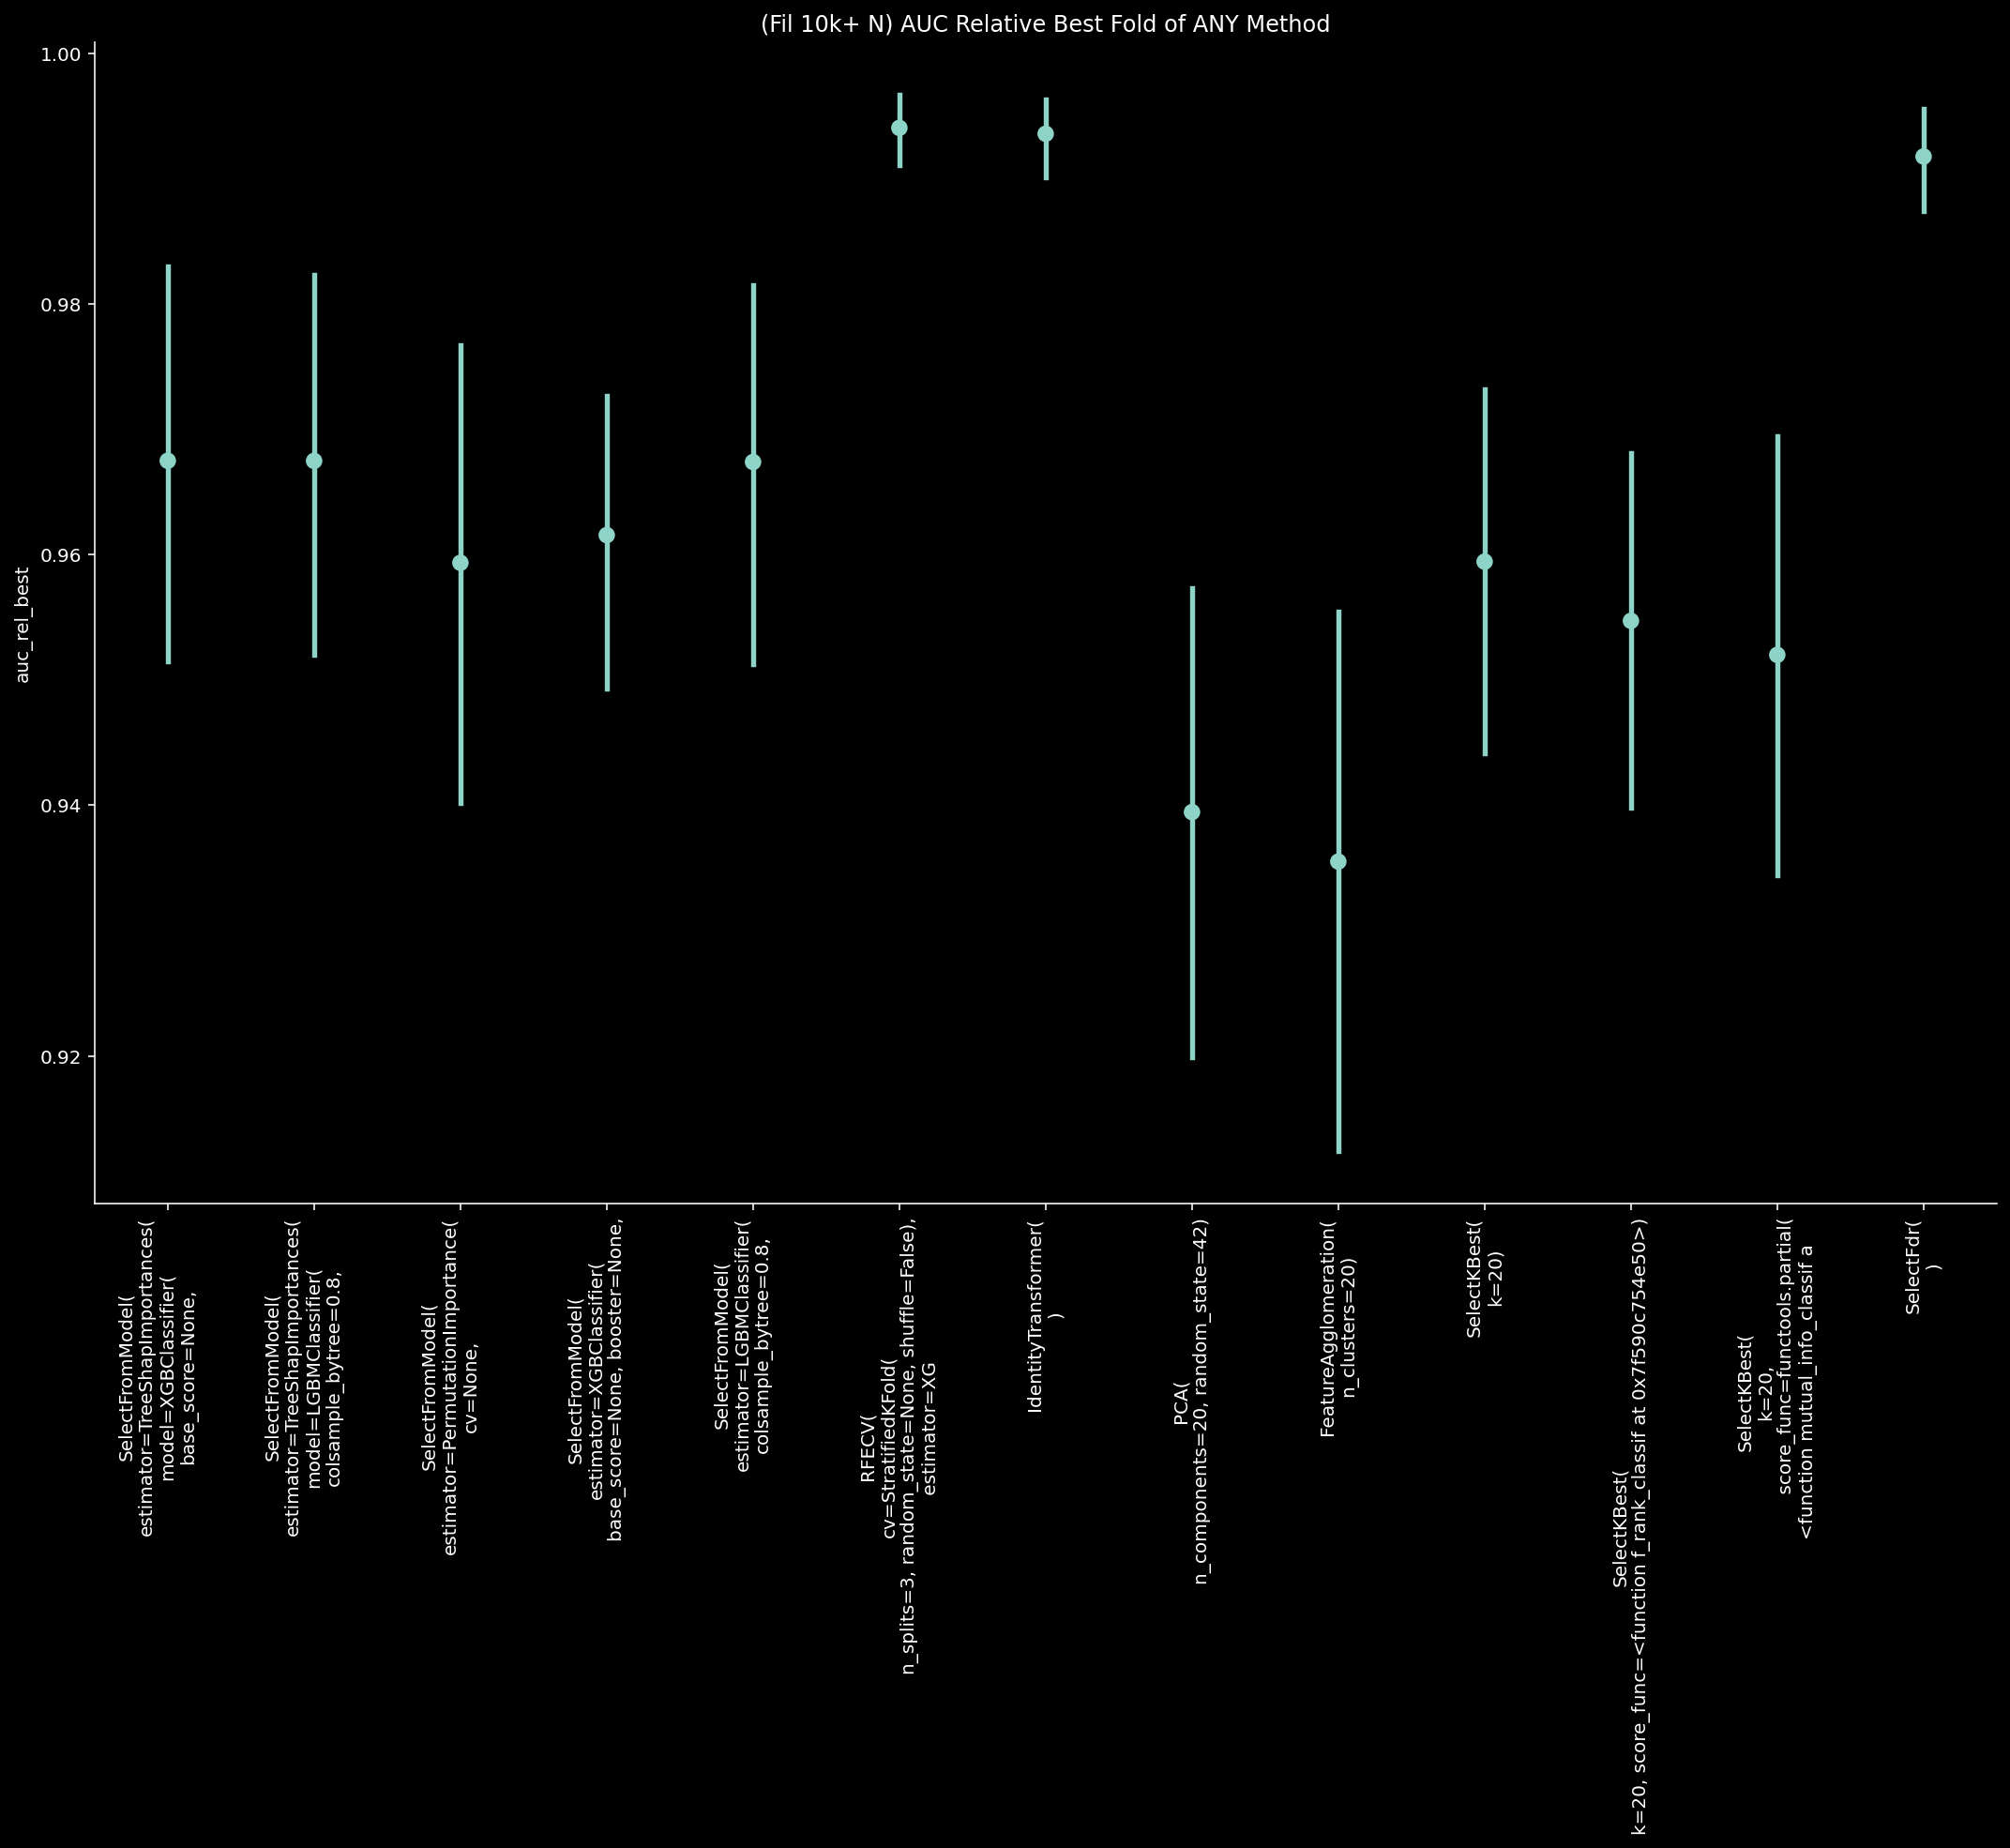

In [61]:
perfs['dimensionality_reduction_short'] = perfs.dimensionality_reduction.str.slice(0, 90).str.replace('(', '(\n')
perfs['auc_rel_best'] = perfs.groupby('dataset_name').roc_auc.apply(lambda ser: ser / ser.max())

ax = sns.catplot(
    x='dimensionality_reduction_short',
    y='auc_rel_best',
    #hue='dataset_name',
    data=perfs.loc[perfs.sample_size > 10_000],
    kind='point',
    join=False,
    alpha=.6,
    height=10, 
    aspect=1.5,
)
_ = plt.xticks(rotation=90)#, fontsize=8)
plt.xlabel('')
plt.title("(Fil 10k+ N) AUC Relative Best Fold of ANY Method")

#### Rest of detailed analysis

In [40]:
#%pdb

In [44]:
#pipe['feature_selector']

#name
#df
#perfs.groupby(['dataset_name']).roc_auc.max()
# --> make sure none .5 or 1 auc

#perfs.roc_auc.mean()#quantile(.9)

# perfs = pd.concat(perfs, axis='rows').reset_index(drop=True)

#higgs.sample(10_000).select_dtypes(include=[np.number]).corr(method='kendall').target.abs().sort_values(ascending=False).head(30)

Text(0.5, 1.0, 'Simple ROC-AUC View')

Text(0.5, 21.70625000000004, '')

<Figure size 1152x576 with 0 Axes>

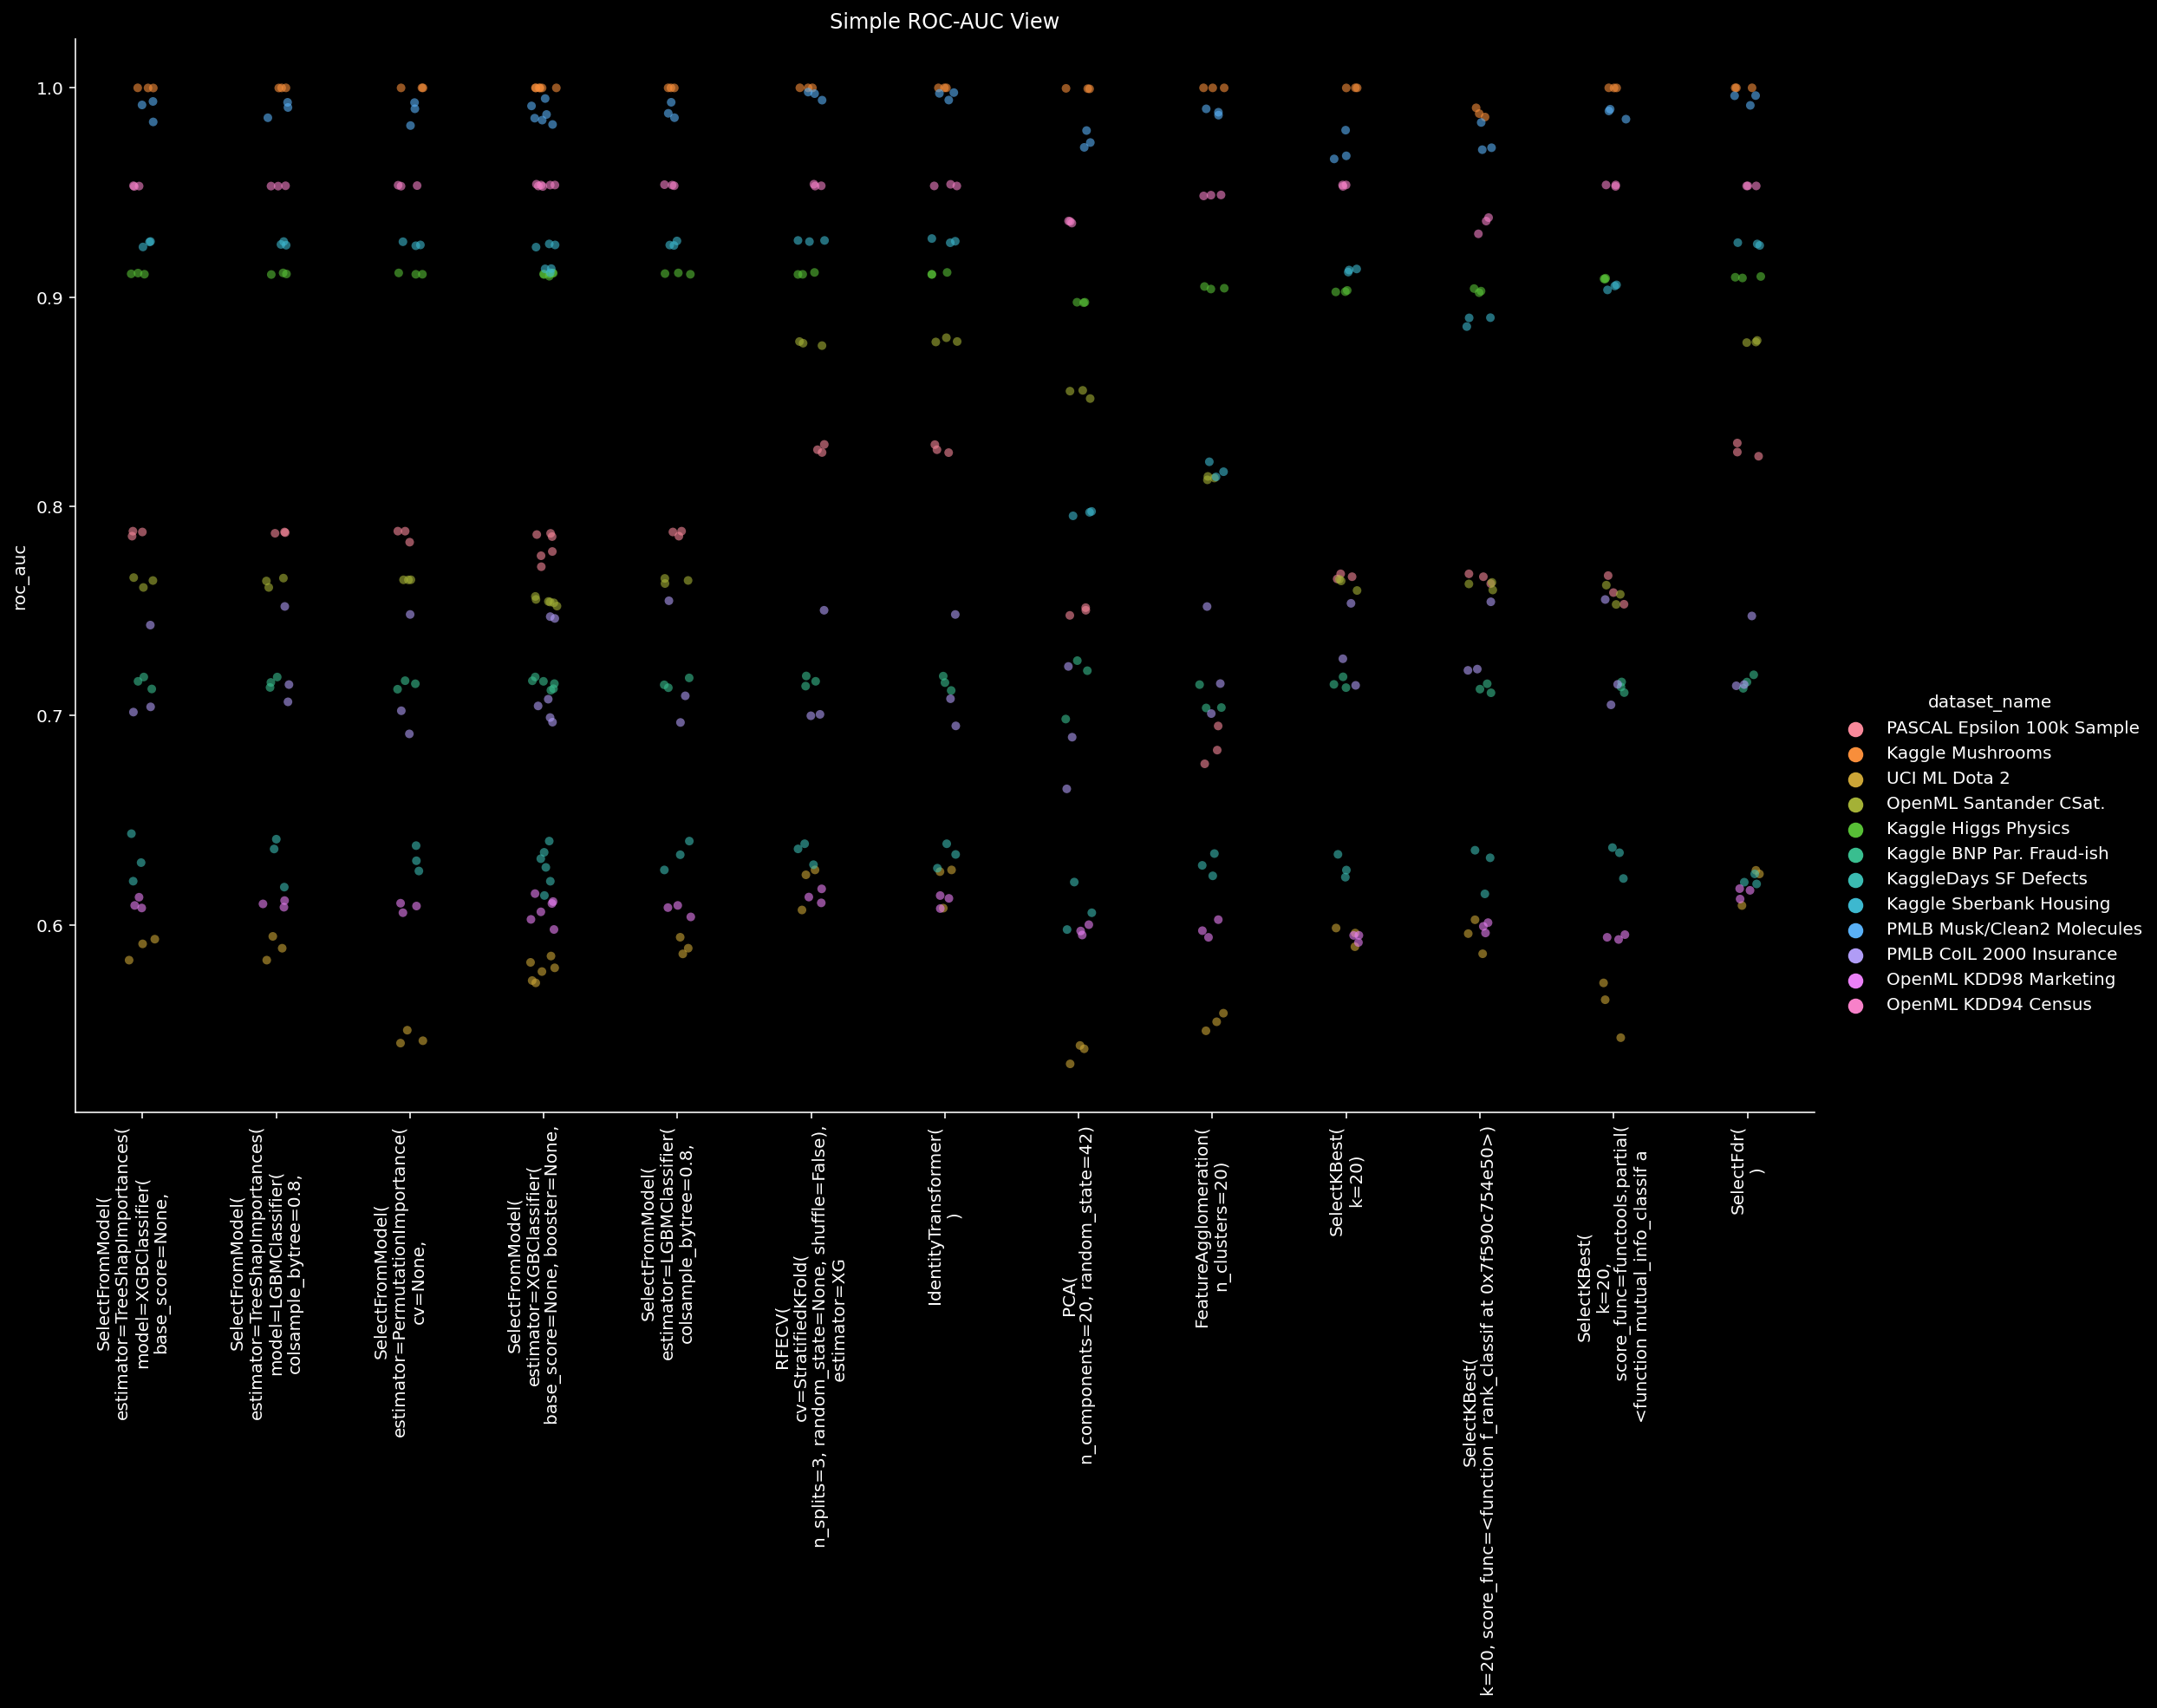

In [62]:

fig = plt.figure(figsize=(16,8))
ax = sns.catplot(
    x='dimensionality_reduction_short',
    y='roc_auc',
    hue='dataset_name',
    data=perfs,
    kind='strip',
    alpha=.6,
    height=10, 
    aspect=1.5,
)
_ = plt.xticks(rotation=90)
plt.title("Simple ROC-AUC View")
plt.xlabel('')

Text(0.5, 1.0, 'Simple ROC-AUC View')

Text(0.5, 21.70625000000004, '')

(0.49, 1.01)

Text(0.5, 1.0, 'Simple ROC-AUC View')

Text(0.5, 21.70625000000004, '')

(0.49, 1.01)

<Figure size 1152x576 with 0 Axes>

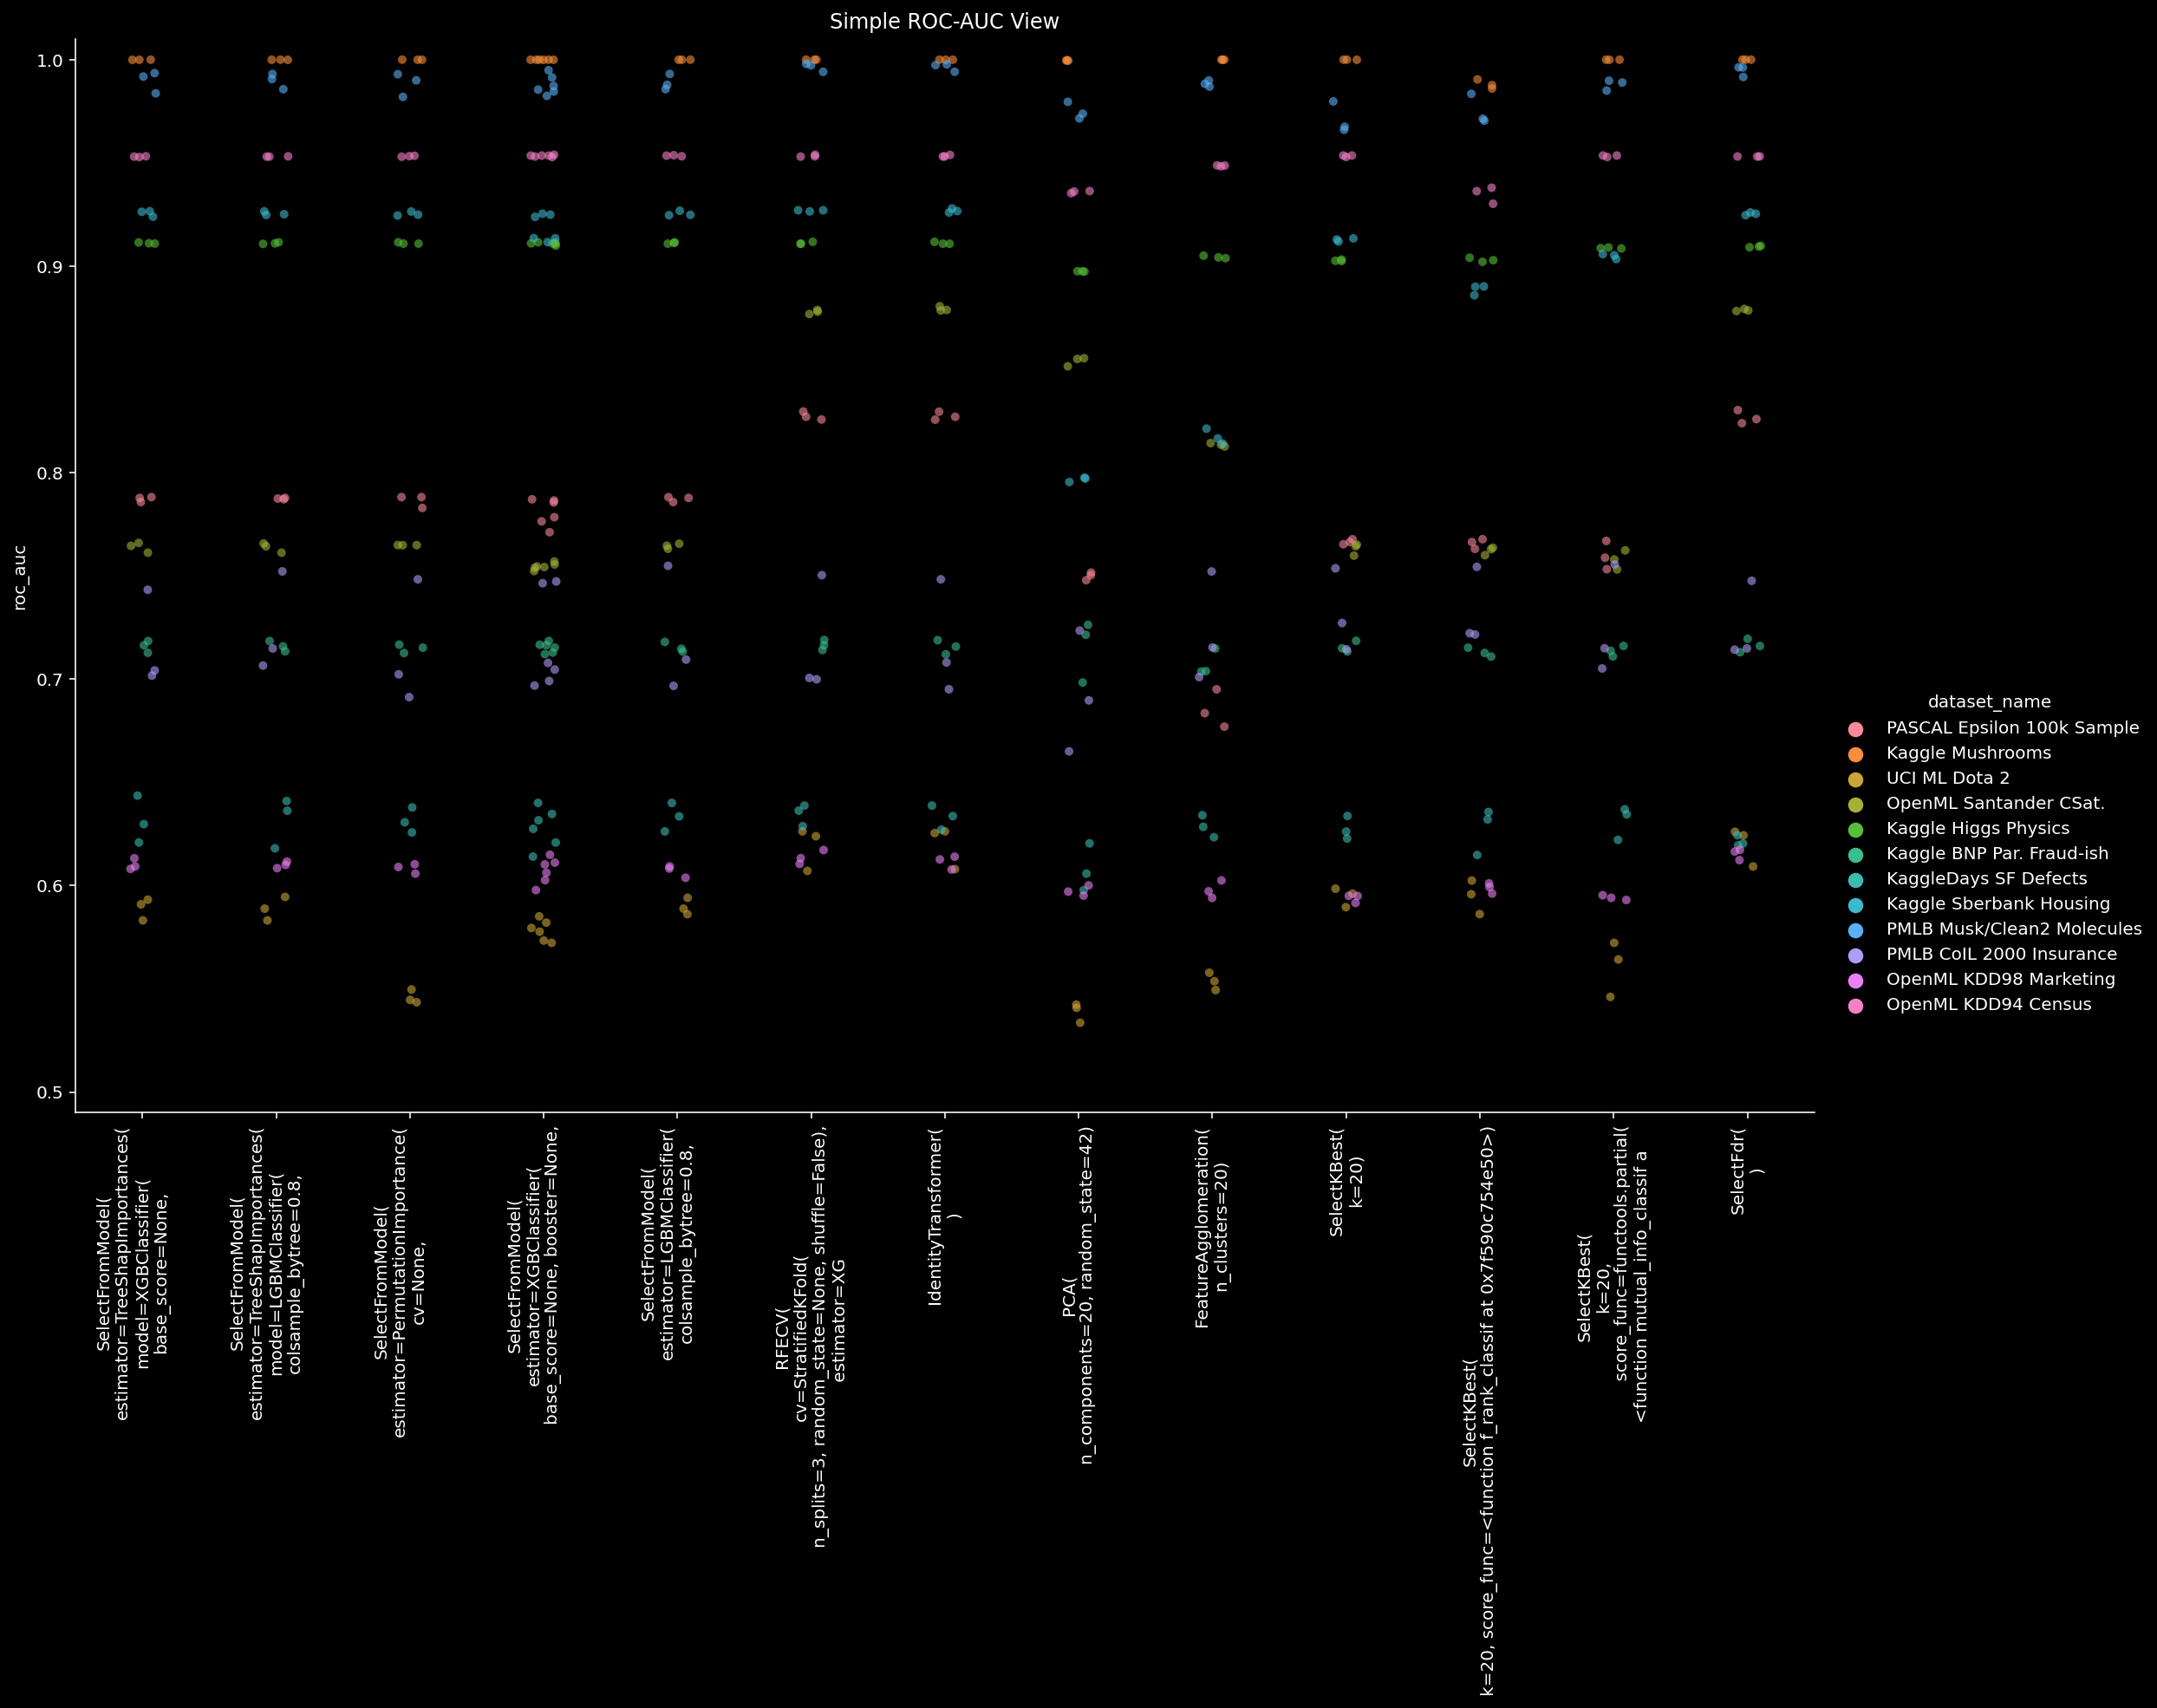

<Figure size 1152x576 with 0 Axes>

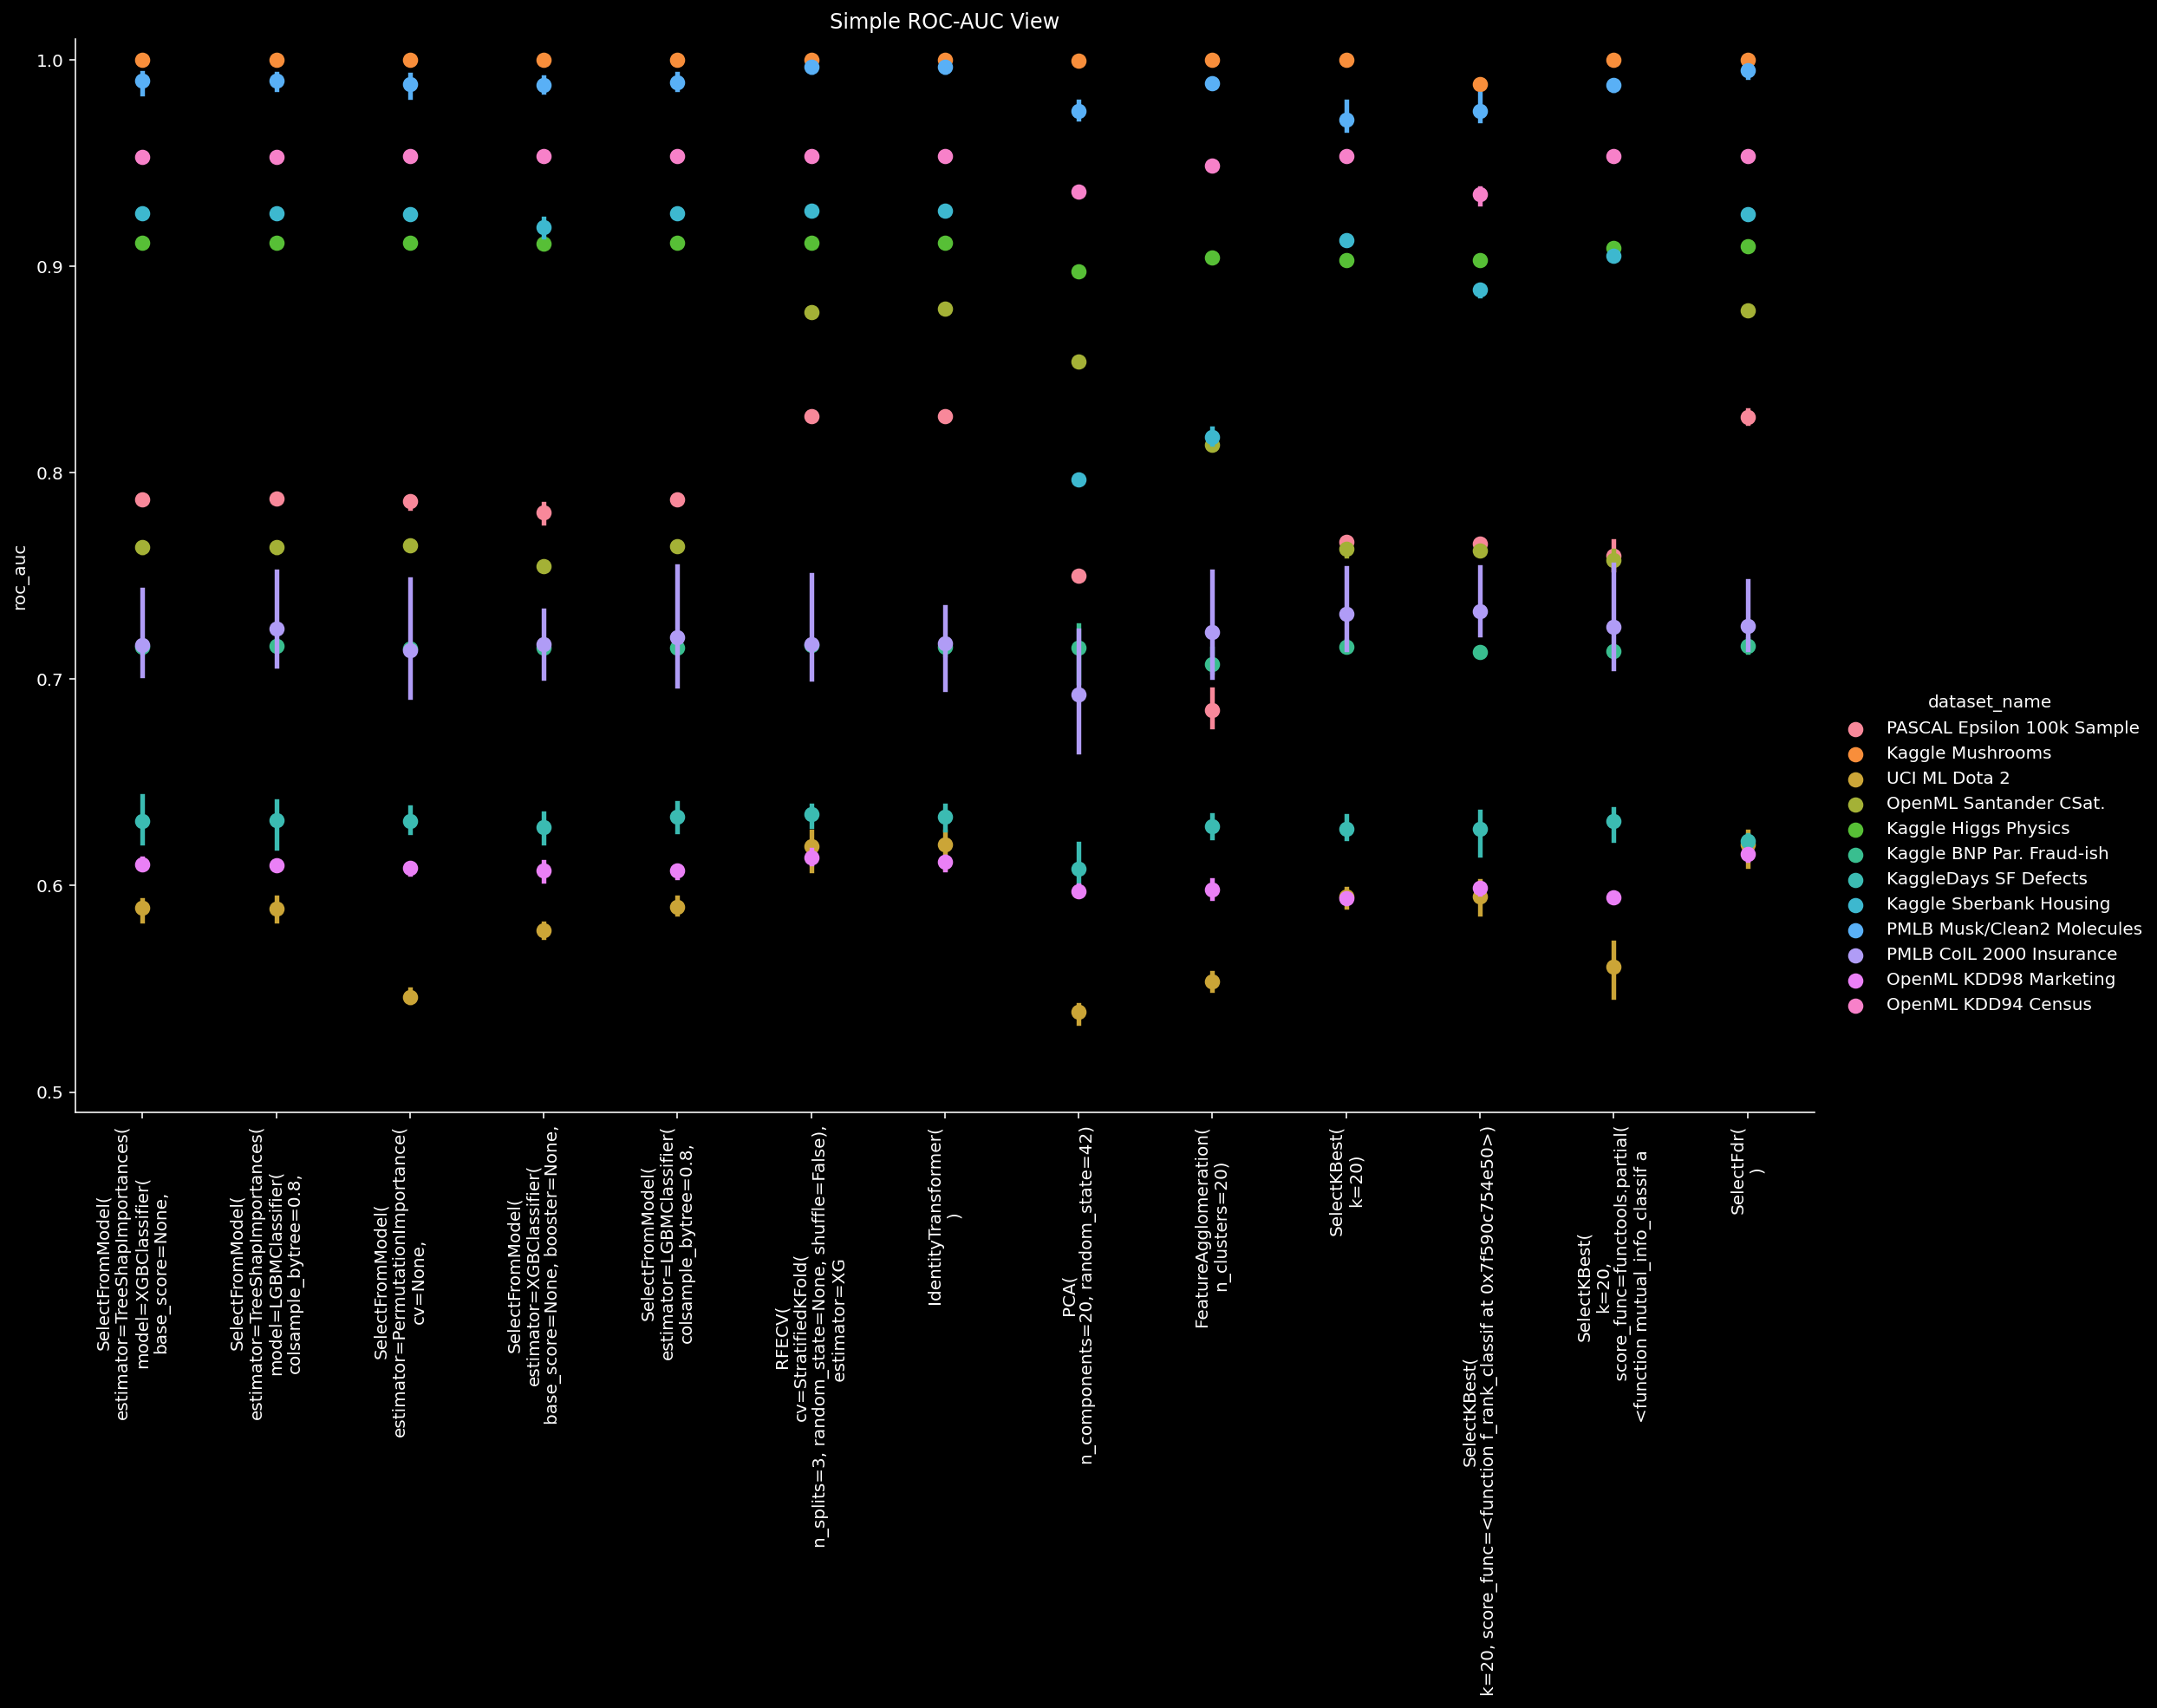

In [63]:
import seaborn as sns

perfs['dimensionality_reduction_short'] = perfs.dimensionality_reduction.str.slice(0, 90).str.replace('(', '(\n')

fig = plt.figure(figsize=(16,8))
ax = sns.catplot(
    x='dimensionality_reduction_short',
    y='roc_auc',
    hue='dataset_name',
    data=perfs,
    kind='strip',
    alpha=.6,
    height=10, 
    aspect=1.5,
)
_ = plt.xticks(rotation=90)
plt.title("Simple ROC-AUC View")
plt.xlabel('')

plt.ylim(0.49, 1.01)

fig = plt.figure(figsize=(16,8))
ax = sns.catplot(
    x='dimensionality_reduction_short',
    y='roc_auc',
    hue='dataset_name',
    data=perfs,
    kind='point',
    join=False,
    height=10, 
    aspect=1.5,
)
_ = plt.xticks(rotation=90)
plt.title("Simple ROC-AUC View")
plt.xlabel('')
plt.ylim(0.49, 1.01)


In [64]:
# x, y = mushrooms.drop('target', axis=1).copy(), mushrooms['target'].copy()
# fitted = pipe.fit(
#     x,
#     y,
# )

# importances = list(zip(
#     mushrooms.drop('target', axis=1).copy().columns,
#     fitted['classifier'].feature_importances_,
# ))

# sorted(importances, key=lambda t:t[1], reverse=True)

In [65]:
# # prototype/debug shap selector

# foo = xgbc_sml.fit(
#     coil2000.drop('target', axis=1).copy(),
#     coil2000['target'].copy(),
# )
# X = coil2000.drop('target', axis=1).copy()
# y = coil2000['target'].copy()
# subsample = 10_000

# if not isinstance(X, pd.DataFrame):
#     X = pd.DataFrame(X)
# cols = X.columns.tolist()
# #self.n_cols = X.shape[1]
# if X.shape[0] > subsample:#self.subsample:
#     X = X.copy().sample(subsample)
# #model = model.fit(X, y)
# explainer = ftshap.Explainer(
#     foo, feature_names=cols
# )
# shap_values = explainer(X, interactions=False)#, n_jobs=1)
# importances = np.mean(np.abs(shap_values.values), axis=1)


In [66]:
#explainer.shap_interaction_values(X)

Text(0.5, 21.70625000000004, '')

Text(0.5, 1.0, 'AUC Relative Best Fold of ANY Method')

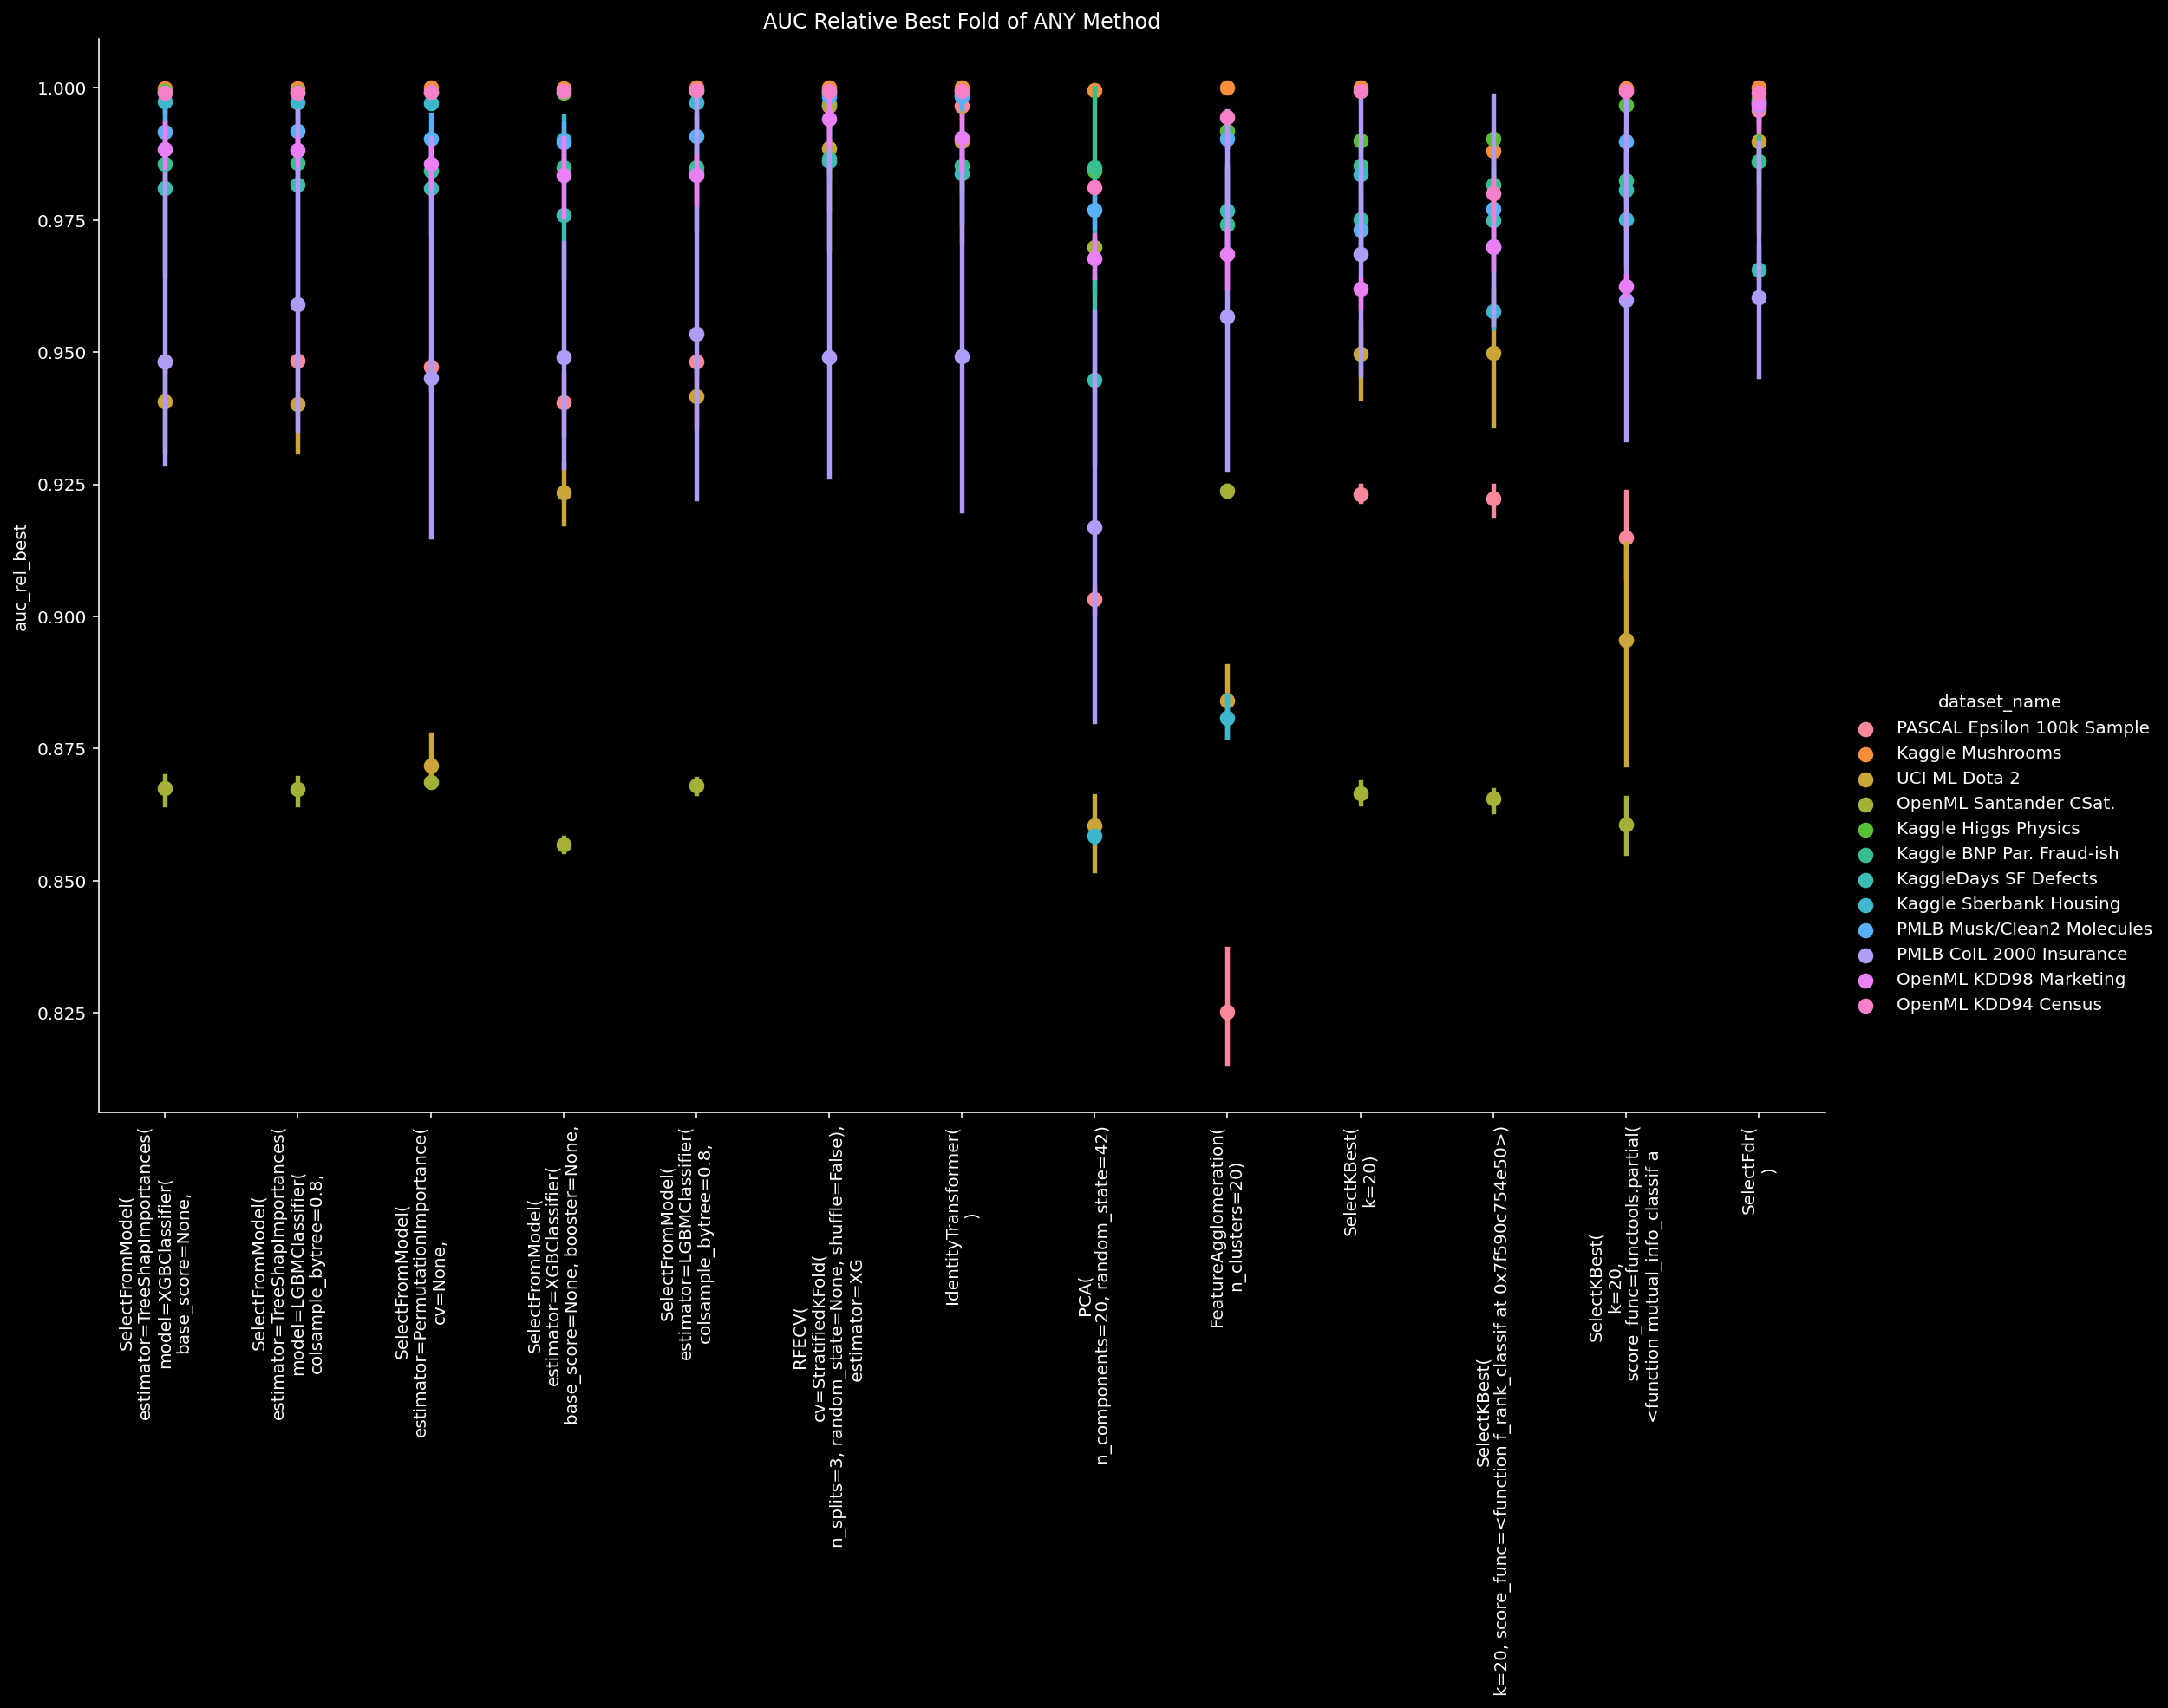

In [67]:

ax = sns.catplot(
    x='dimensionality_reduction_short',
    y='auc_rel_best',
    hue='dataset_name',
    data=perfs,
    kind='point',
    join=False,
    alpha=.6,
    height=10, 
    aspect=1.5,
)
_ = plt.xticks(rotation=90)#, fontsize=8)
plt.xlabel('')
plt.title("AUC Relative Best Fold of ANY Method")
#plt.ylim(0.49, 1.01)


In [68]:
# import statsmodels.formula.api as smf

# model = smf.ols(
#     'auc_rel_best ~ dimensionality_reduction_short + dataset_name',#sample_size	n_features_base
#     data=perfs,
# )
# fitted = model.fit(cov_type='HC3')
# fitted.summary()

In [69]:
print("Note: 'ROC-AUC rel. best' = AUC / best fold AUC of any model")
print('\n\nAll datasets avg. ROC-AUC rel. best by model:')
(
    perfs.groupby('dimensionality_reduction_short')
         .auc_rel_best
         .mean()
         .round(4)
         .sort_values(ascending=False)
)

print('\n\nExluding <10k N, avg. ROC-AUC rel. best by model:')
(
    perfs.loc[perfs.sample_size > 10_000]
         .groupby('dimensionality_reduction_short')
         .auc_rel_best
         .mean()
         .round(4)
         .sort_values(ascending=False)
)

print('\n\nOn two small-ish (N 2-10K) datasets, avg. ROC-AUC rel. best by model:')
(
    perfs.loc[perfs.sample_size < 10_000]
         .groupby('dimensionality_reduction_short')
         .auc_rel_best
         .mean()
         .round(4)
         .sort_values(ascending=False)
)

Note: 'ROC-AUC rel. best' = AUC / best fold AUC of any model


All datasets avg. ROC-AUC rel. best by model:


dimensionality_reduction_short
RFECV(\ncv=StratifiedKFold(\nn_splits=3, random_state=None, shuffle=False),\n      estimator=XG      0.9911
IdentityTransformer(\n)                                                                              0.9908
SelectFdr(\n)                                                                                        0.9902
SelectFromModel(\nestimator=TreeShapImportances(\nmodel=LGBMClassifier(\ncolsample_bytree=0.8,\n     0.9715
SelectFromModel(\nestimator=LGBMClassifier(\ncolsample_bytree=0.8,\n                                 0.9709
SelectFromModel(\nestimator=TreeShapImportances(\nmodel=XGBClassifier(\nbase_score=None,\n           0.9706
SelectFromModel(\nestimator=XGBClassifier(\nbase_score=None, booster=None,\n                         0.9661
SelectKBest(\nk=20)                                                                                  0.9647
SelectFromModel(\nestimator=PermutationImportance(\ncv=None,\n                                       0.96



Exluding <10k N, avg. ROC-AUC rel. best by model:


dimensionality_reduction_short
RFECV(\ncv=StratifiedKFold(\nn_splits=3, random_state=None, shuffle=False),\n      estimator=XG      0.9940
IdentityTransformer(\n)                                                                              0.9936
SelectFdr(\n)                                                                                        0.9918
SelectFromModel(\nestimator=TreeShapImportances(\nmodel=LGBMClassifier(\ncolsample_bytree=0.8,\n     0.9675
SelectFromModel(\nestimator=TreeShapImportances(\nmodel=XGBClassifier(\nbase_score=None,\n           0.9675
SelectFromModel(\nestimator=LGBMClassifier(\ncolsample_bytree=0.8,\n                                 0.9674
SelectFromModel(\nestimator=XGBClassifier(\nbase_score=None, booster=None,\n                         0.9615
SelectKBest(\nk=20)                                                                                  0.9594
SelectFromModel(\nestimator=PermutationImportance(\ncv=None,\n                                       0.95



On two small-ish (N 2-10K) datasets, avg. ROC-AUC rel. best by model:


dimensionality_reduction_short
SelectFdr(\n)                                                                                        0.9857
SelectFromModel(\nestimator=TreeShapImportances(\nmodel=LGBMClassifier(\ncolsample_bytree=0.8,\n     0.9836
SelectKBest(\nk=20,\n            score_func=functools.partial(\n<function mutual_info_classif a      0.9833
IdentityTransformer(\n)                                                                              0.9826
RFECV(\ncv=StratifiedKFold(\nn_splits=3, random_state=None, shuffle=False),\n      estimator=XG      0.9825
FeatureAgglomeration(\nn_clusters=20)                                                                0.9824
SelectFromModel(\nestimator=LGBMClassifier(\ncolsample_bytree=0.8,\n                                 0.9815
SelectKBest(\nk=20)                                                                                  0.9806
SelectFromModel(\nestimator=TreeShapImportances(\nmodel=XGBClassifier(\nbase_score=None,\n           0.98

In [70]:
perfs.groupby('dataset_name').roc_auc.max().round(4).sort_values(ascending=False)

dataset_name
Kaggle Mushrooms              1.0000
PMLB Musk/Clean2 Molecules    0.9980
OpenML KDD94 Census           0.9539
Kaggle Sberbank Housing       0.9280
Kaggle Higgs Physics          0.9118
OpenML Santander CSat.        0.8806
PASCAL Epsilon 100k Sample    0.8303
PMLB CoIL 2000 Insurance      0.7555
Kaggle BNP Par. Fraud-ish     0.7263
KaggleDays SF Defects         0.6436
UCI ML Dota 2                 0.6262
OpenML KDD98 Marketing        0.6173
Name: roc_auc, dtype: float64

Text(0.5, 1.0, 'Runtime Comparison')

Text(0.5, 21.70625000000004, '')

<Figure size 1152x576 with 0 Axes>

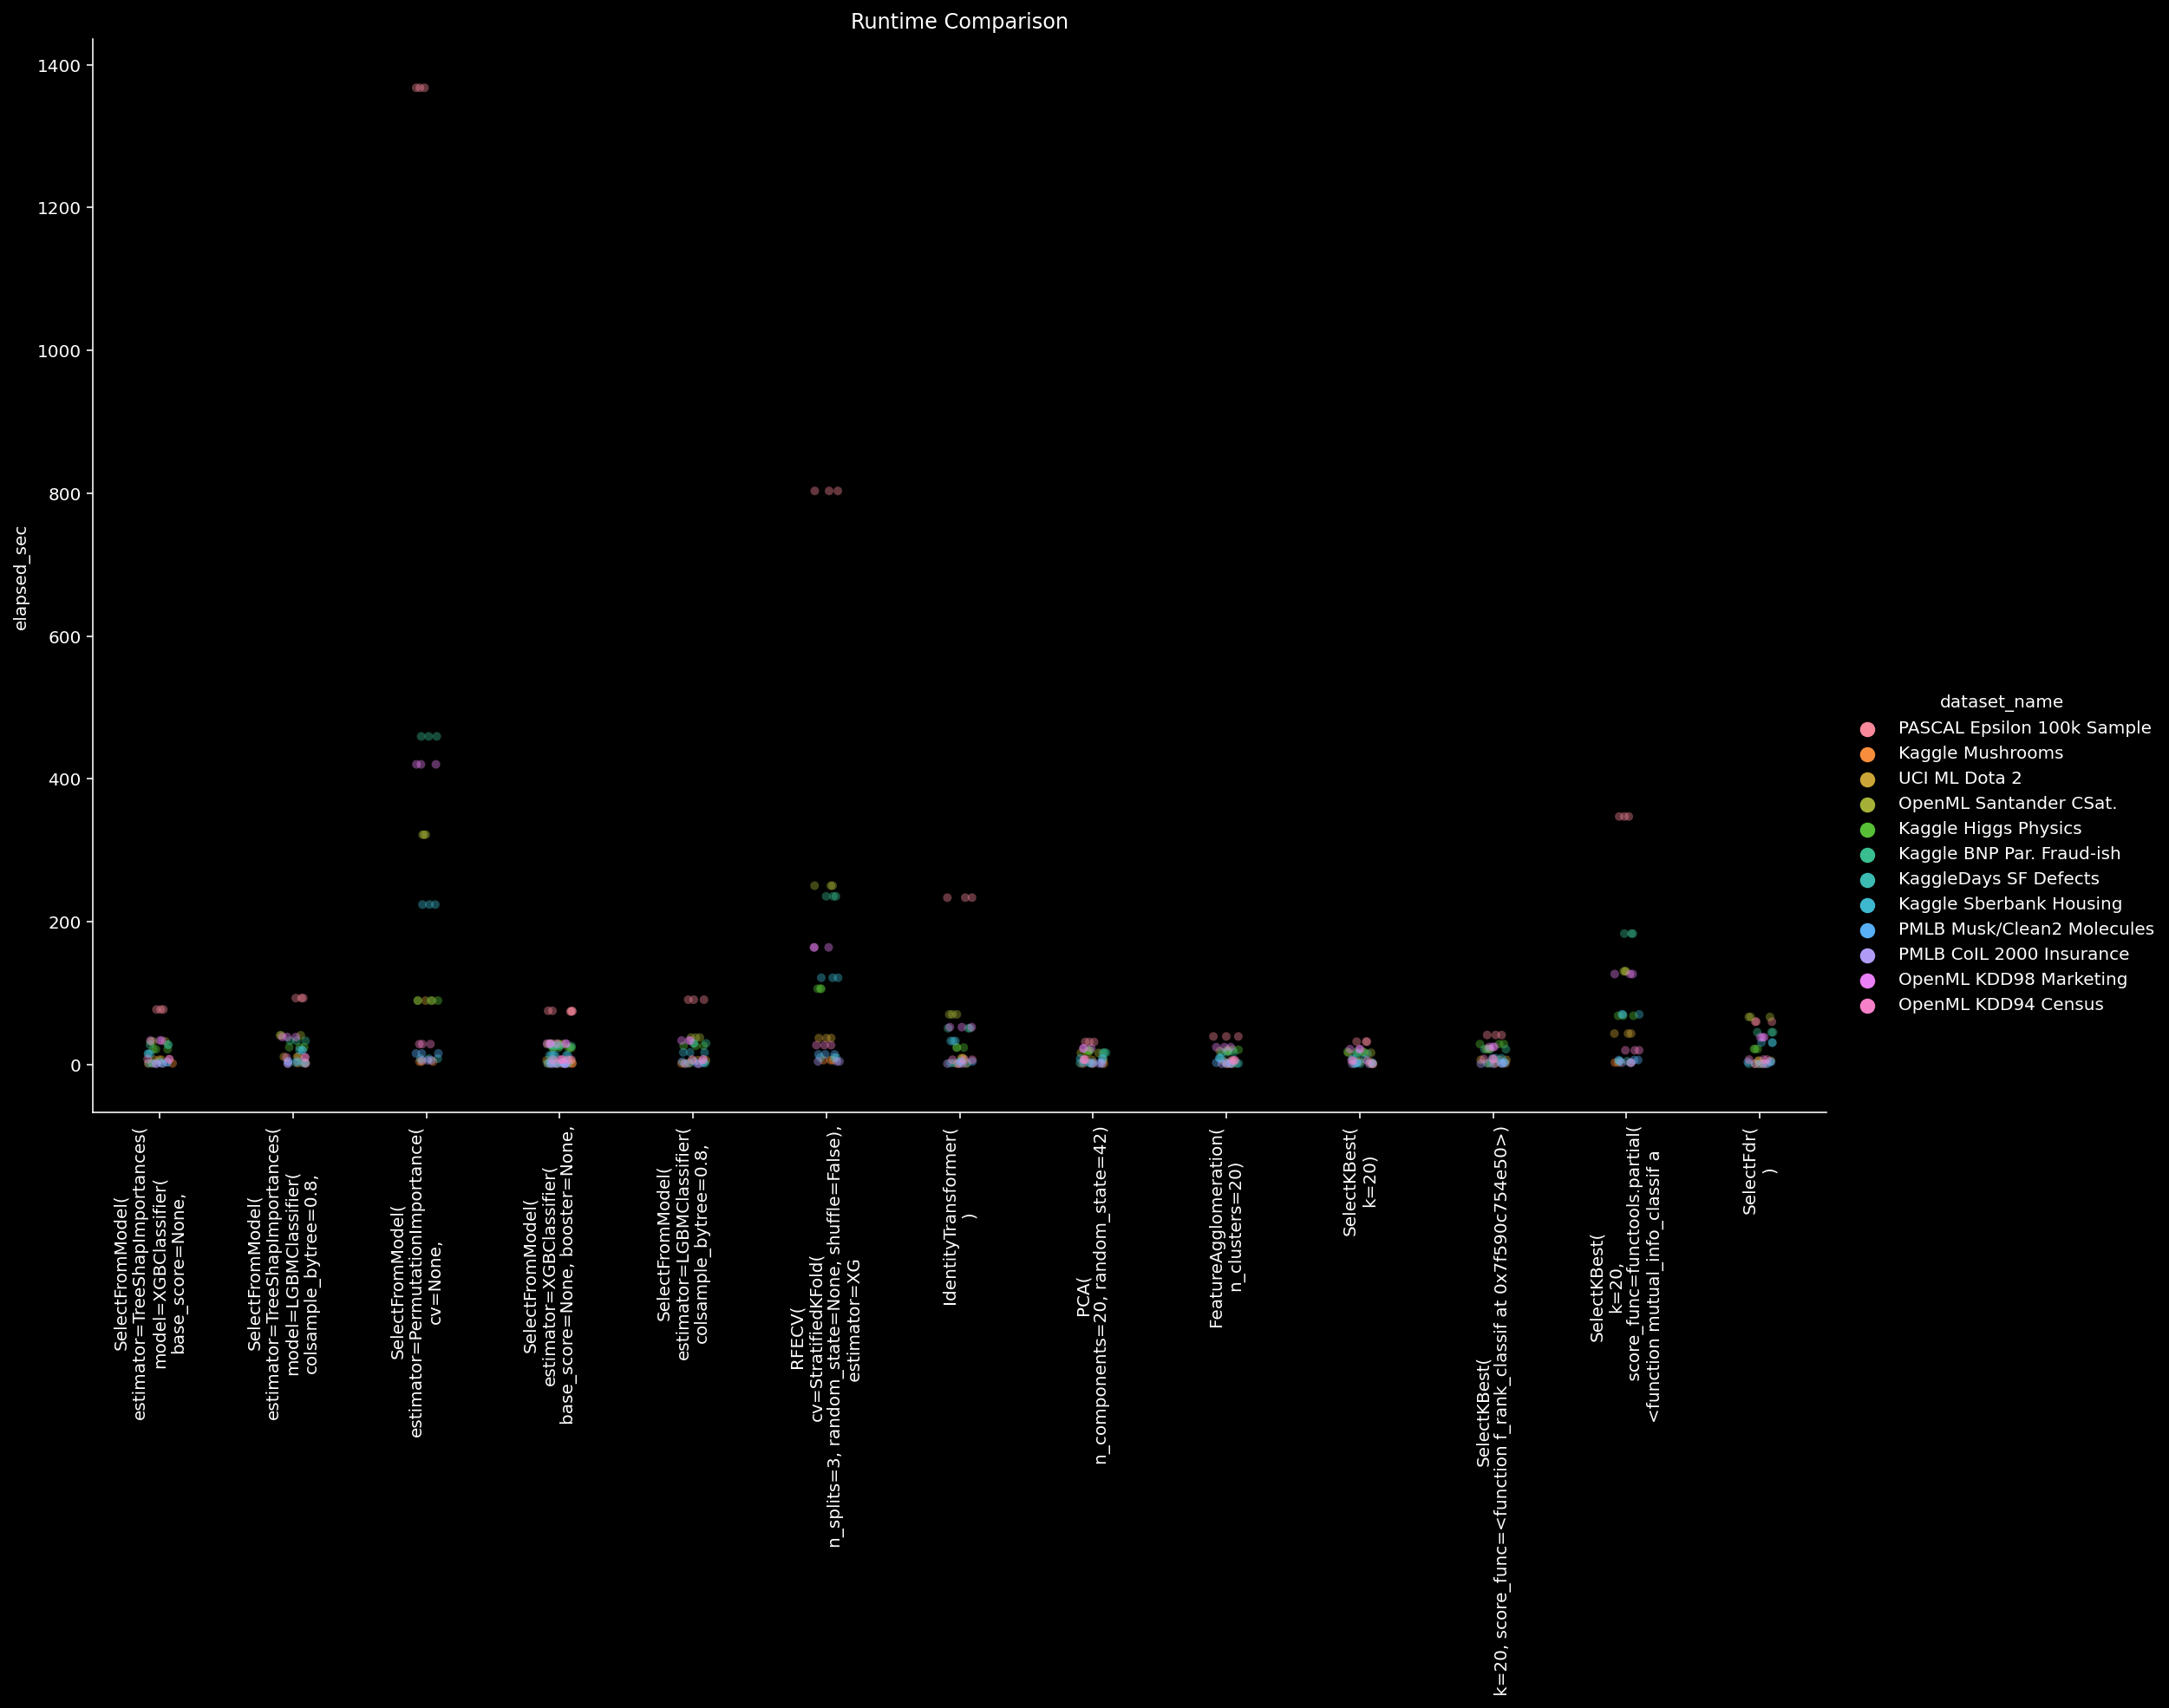

In [71]:
fig = plt.figure(figsize=(16,8))
perfs['elapsed_sec_log10'] = np.log10(perfs.elapsed_sec)
ax = sns.catplot(
    x='dimensionality_reduction_short',
    y='elapsed_sec',
    hue='dataset_name',
    data=perfs,
    kind='strip',
    #join=False,
    #orient='h',
    alpha=.4,
    height=10, 
    aspect=1.5,
)
_ = plt.xticks(rotation=90)
plt.title("Runtime Comparison")
plt.xlabel('')

#plt.ylim(0.49, 1.01)

Text(0.5, 1.0, 'Which perform better in high- vs low-dimesnional feature spaces?')

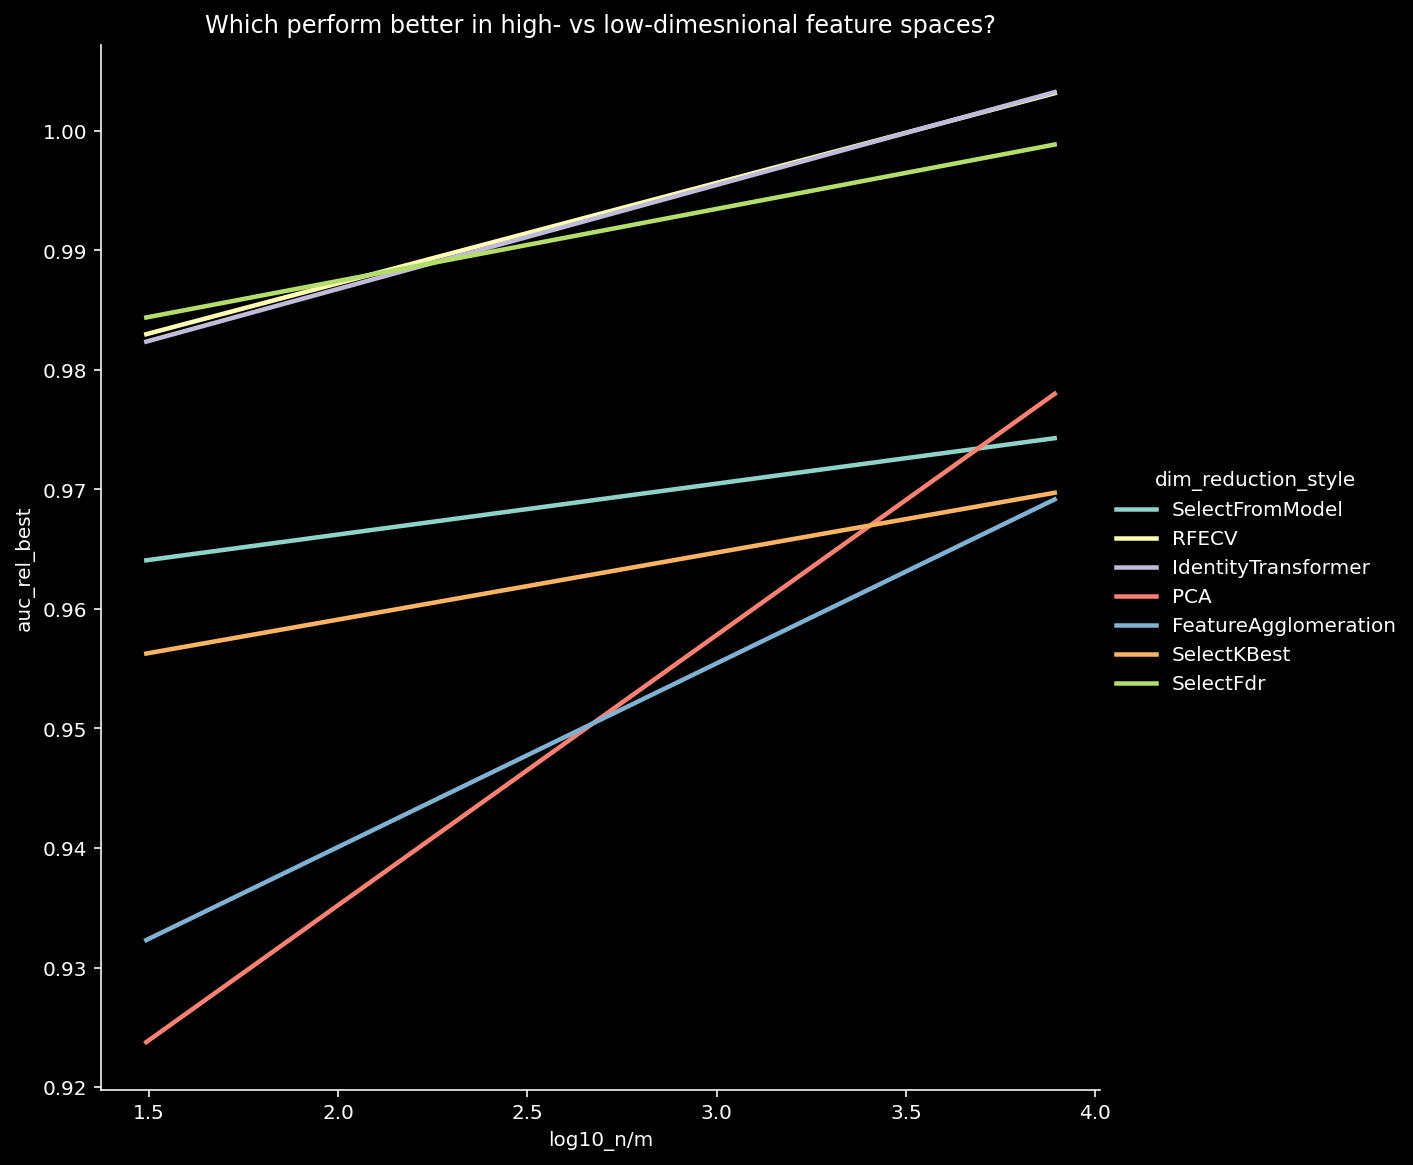

In [80]:
perfs['n/m'] = perfs['m/n'].copy()
perfs['log10_n/m'] = np.log10(perfs['n/m'])
perfs['dim_reduction_style'] = perfs.dimensionality_reduction_short.str.split('(').apply(lambda l: l[0])

sns.lmplot(
    x='log10_n/m',
    y='auc_rel_best',
    hue='dim_reduction_style',
    data=perfs,
    ci=None,
    scatter=False,
    height=8,
)

plt.title("Which perform better in high- vs low-dimesnional feature spaces?")

pretty cool! identity transformer seems to do best when roughly 100-1000x as many examples as features, else filtering by FDR does better. RFE always works well, but will cost you model fitting time.  

Keeping in mind they are k-best and not directly comparable, selecting from a tree model does better across the board for these problems vs. by univariate filters. PCA and feature agglomeration seem to benefit more from high n/m as well(???)  

_caveat literally 12 datasets so these slopes have a whole lot of associated uncertainty which I've omitted_

In [81]:
import gc
gc.collect()

45

In [82]:
perfs_old = perfs.copy()

### Appendices + Graveyard